## DATA PREPROCESSING

In [1]:
import os
%reset

from datetime import datetime, timedelta
import pandas as pd
from os import listdir
from os.path import isfile, join, isdir

database_dir = './2023'              #It should be made sure that there are equal number of data and ref folders here

pre_processed_dir = './Preprocessed data'

#------------The main data directory contains data and ref folder for each month's data------------#
folders_in_data_dir = [folder for folder in listdir(database_dir) if isdir(join(database_dir, folder))]
data_tables_folder = [folder for folder in folders_in_data_dir if (("ref" not in folder) and ("Ref" not in folder) and ("20230630" in folder))]
reference_folder = [folder for folder in folders_in_data_dir if (("20230630" and "ref" in folder) or ("20230630" and "Ref" in folder))]

"""file_names =
['20150401', '20150501', '20150602', '20150701', '20150801', '20150829', '20150926', '20151031', '20151128', '20160109', '20160130', '20160227', '20160402', '20160430', '20160528', '20160630', '20160730', '20160827', '20160930', '20161028', '20161126', '20161224', '20170128', '20170225', '20170401', '20170429', '20170531', '20170701', '20170729', '20170831', '20171005', '20171031', '20171130', '20171222', '20180131', '20180228', '20180330', '20180427', '20180531', '20180629', '20180801', '20180831', '20180930', '20181031', '20181130', '20181231', '20190131', '20190228', '20190331', '20190430', '20190529', '20190628', '20190801', '20190830', '20191001', '20191031', '20191129', '20200101', '20200131', '20200301', '20200401', '20200430', '20200529', '20200630', '20200731', '20200831', '20200930', '20201030', '20201201', '20210107', '20210129', '20210226', '20210331', '20210503', '20210531', '20210630', '20210801', '20210930', '20211029', '20211130', '20211223', '20220131', '20220228', '20220331', '20220429', '20220531', '20220630', '20220729', '20220831', '20220930', '20221028', '20221130', '20221223', '20230201', '20230301', '20230402', '20230428', '20230531']"""

file_names = ['20230630']

# Create text files with the given names in the folder

#already_processed = [file.split('.')[0] for file in listdir(pre_processed_dir) if isfile(join(pre_processed_dir, file))]
already_processed = file_names
print("------------------------------------ALL Folders------------------------------------")
print(folders_in_data_dir)

print("------------------------------------Data Folders------------------------------------")
print(data_tables_folder)

print("------------------------------------Reference Folders------------------------------------")
print(reference_folder)

print("------------------------------------Dates already Processed-----------------------------------")
print(already_processed)

total_num_bs_df = pd.DataFrame(columns=['Dates', 'Total_NUM_BSs'])         #We will save this in a file at the end. For comparison with the number of stations of the 4 main operators.
if 'NUM_STATIONS' in already_processed:
    total_num_bs_df = pd.read_csv(join(pre_processed_dir, 'NUM_STATIONS.txt'), sep = ';')

------------------------------------ALL Folders------------------------------------
['20230630-export-etalab-data', '20230630-export-etalab-ref']
------------------------------------Data Folders------------------------------------
['20230630-export-etalab-data']
------------------------------------Reference Folders------------------------------------
['20230630-export-etalab-ref']
------------------------------------Dates already Processed-----------------------------------
['20230630']


## DATA PREPARATION

In [2]:
#---------------------------------Finding the mapping between the data and the ref folders---------------------------------#
dates = []
mapped_folders = []       #This list will contain each data and ref folder name in sequence. First data then ref for the same month and then so on.

months = ['janvier', 'février', 'mars', 'avril', 'mai', 'juin', 'juillet', 'aout', 'septembre', 'octobre', 'novembre', 'décembre']

for current_data_folder in data_tables_folder:
    mapped_folders.append(current_data_folder)

    data_date = ''
    #---------if data folder is named in this format -->'tables-supports-antennes-emetteurs-bandes-janvier-2020'---------#
    for month in months:
        if month in current_data_folder:
            month_number = months.index(month) + 1
            if month_number < 10:
                month_number = '0' + str(month_number)
            year = current_data_folder.split('-')[6]
            day = '01'
            data_date = year + month_number + day
    #---------if data folder is named in this format -->'20211029-export-etalab-data'---------Doesn't matter if there is no data in the name#
    if data_date == '':
        if len(current_data_folder.split('-')) > 1:
            data_date = current_data_folder.split('-')[0]
        else:
            data_date = current_data_folder.split('_')[0]    #Some folders use underscore instead of dash
    dates.append(data_date)

    for current_ref_folder in reference_folder:
        ref_date = ''
        #---------if ref folder is named in this format -->'table-de-reference-mars-2020'---------#
        for month in months:
            if month in current_ref_folder:
                month_number = months.index(month) + 1
                if month_number < 10:
                    month_number = '0' + str(month_number)
                year = current_ref_folder.split('-')[4]
                day = '01'
                ref_date = year + month_number + day
        #---------if data folder is named in this format -->'20210801-export-etalab-ref'---------#
        if ref_date == '':
            if len(current_ref_folder.split('-')) > 1:
                ref_date = current_ref_folder.split('-')[0]
            else:
                ref_date = current_ref_folder.split('_')[0]    #Some folders use underscore instead of dash

        date_diff = abs(datetime.strptime(data_date, '%Y%m%d') - datetime.strptime(ref_date, '%Y%m%d'))

        if date_diff < timedelta(days = 7):     #Assuming that the difference between the upload of data and ref folders won't be more than 5 days. Less than 5 days mean they belong to the same set. Also assuming that different months data is upload after at least 5 days
            mapped_folders.append(current_ref_folder)
            break

print("----------------------Dates----------------------")
print(dates)

print("----------------------Mapped Folders (In a list one after the another)----------------------")
print(mapped_folders)

----------------------Dates----------------------
['20230630']
----------------------Mapped Folders (In a list one after the another)----------------------
['20230630-export-etalab-data', '20230630-export-etalab-ref']


In [4]:
#Methods for using below: For adding the FDD BW and TDD BW columns in the dataframe.
def add_FDD_BW_col(row):
    if row['DUPLEX_TYPE'] == 'F' or row['DUPLEX_TYPE'] == 'T&F':
        return row['BW']
    else:
        return 0

def add_TDD_BW_col(row):
    if row['DUPLEX_TYPE'] == 'T' or row['DUPLEX_TYPE'] == 'T&F':
        return row['BW']
    else:
        return 0

## DATA CLEANING

In [ ]:
encoding_type = 'latin1'              #This type of encoding is well adapted for Western European languages.

for i in range(0, len(mapped_folders), 2):
    data_path = join(database_dir, mapped_folders[i])
    reference_path = join(database_dir, mapped_folders[i + 1])

    data_date = dates[i//2]

    #if data_date in already_processed:
        #continue

    print("Currently PreProcessing")
    print(data_path)
    print(reference_path)

    #-----------------Converting reference files to dataframes - will be used to find mapping in the data files-----------------#
    operators_df = pd.read_csv(join(reference_path, 'SUP_EXPLOITANT.txt'), sep = ';', dtype=str, encoding=encoding_type, on_bad_lines='skip')       #Not entirely sure why but this encoding type works for all. On_bad_lines for ID 244 -->skipping it.
    antenna_type_df = pd.read_csv(join(reference_path, 'SUP_TYPE_ANTENNE.txt'), sep = ';', dtype=str, encoding=encoding_type)
    #-----------------Creating dictionaries from the reference dataframes-----------------#
    operators_mapping = operators_df.set_index('ADM_ID').T.to_dict('index')
    operators_mapping = operators_mapping['ADM_LB_NOM']                    #The actual dictionary is a nested dictionary

    antenna_type_mapping = antenna_type_df.set_index('TAE_ID').T.to_dict('index')
    antenna_type_mapping = antenna_type_mapping['TAE_LB']                  #The actual dictionary is a nested dictionary

    #-----------------Reading actual datafiles as panda dataframes-----------------#
    station_df = pd.read_csv(join(data_path, 'SUP_STATION.txt'), sep = ';', dtype=str, encoding=encoding_type)

    #In earlier files this header is not capitalized so we need to check and get it so that we can extract this col if needed
    service_date_col_name = ''
    col_names_in_station_df = station_df.columns
    for col_name in col_names_in_station_df:
            if 'dte_en_service' in col_name.lower():
                service_date_col_name = col_name

    station_df = station_df[['STA_NM_ANFR','ADM_ID', service_date_col_name]]                                                   #Selecting all the stations assuming all are in service
    #In some earlier data files, in the ADM_ID column there are commas in the data file but not in the reference file so we need to take care of this
    station_df['ADM_ID'] = station_df['ADM_ID'].str.split(',').str.get(0)
    #----------------------Replacing the values in the data columns using the reference----------------------#
    station_df['ADM_ID'] = station_df['ADM_ID'].map(operators_mapping)

    antenna_df = pd.read_csv(join(data_path, 'SUP_ANTENNE.txt'), sep = ';', dtype=str, encoding=encoding_type)
    antenna_df = antenna_df[['STA_NM_ANFR', 'AER_ID', 'TAE_ID']]
    #----------------------Replacing the values in the data columns using the reference----------------------#
    antenna_df['TAE_ID'] = antenna_df['TAE_ID'].map(antenna_type_mapping)

    transmitter_df = pd.read_csv(join(data_path, 'SUP_EMETTEUR.txt'), sep = ';', dtype=str, encoding=encoding_type)

    transmitter_df = transmitter_df[['STA_NM_ANFR', 'EMR_ID', 'EMR_LB_SYSTEME', 'AER_ID']]
    #-----------------------Only cellular systems-----------------------#
    cellular_systems = ['GSM', 'UMTS', 'LTE', '5G']
    transmitter_df = transmitter_df[transmitter_df['EMR_LB_SYSTEME'].str.split(' ').str[0].isin(cellular_systems)]
    transmitter_df = transmitter_df[~transmitter_df['EMR_LB_SYSTEME'].str.contains(" Expe")]             #No experimential bands
    transmitter_df = transmitter_df[~transmitter_df['EMR_LB_SYSTEME'].str.contains(" R")]                #No GSM R
    transmitter_df = transmitter_df[~transmitter_df['EMR_LB_SYSTEME'].str.contains(" P")]                #No Private LTE

    band_df = pd.read_csv(join(data_path, 'SUP_BANDE.txt'), sep = ';', dtype=str, encoding=encoding_type)
    band_df = band_df[['STA_NM_ANFR', 'BAN_ID', 'EMR_ID', 'BAN_NB_F_DEB', 'BAN_NB_F_FIN', 'BAN_FG_UNITE']]

    #--------------Sequential inner join operations to create one single dataframe--------------#
    station_antenna_df = station_df.merge(antenna_df, on = ['STA_NM_ANFR'])
    station_antenna_transmitter_df = station_antenna_df.merge(transmitter_df, on = ['AER_ID', 'STA_NM_ANFR'])
    all_df = station_antenna_transmitter_df.merge(band_df, on = ['EMR_ID', 'STA_NM_ANFR'])

    #Dropping any rows with NaN values #Especially, where DT_EN_SERVICE is null, we are assuming that the stations are not in service.
    all_df = all_df.dropna()
    #--------------Saving the total number of in service base stations--------------#
    num_bs = all_df['STA_NM_ANFR'].nunique()
    row = [data_date, num_bs]
    total_num_bs_df.loc[-1] = row
    total_num_bs_df =  total_num_bs_df.reset_index(drop=True)

    #-----------------------Selecting the stations only from the main cellular operators-----------------------#
    main_operators = ['BOUYGUES TELECOM', 'ORANGE', 'SFR', 'FREE MOBILE']
    all_df = all_df.loc[all_df['ADM_ID'].isin(main_operators)]

    #--------------Replacing comma with decimal--------------#
    all_df['BAN_NB_F_DEB'] = all_df['BAN_NB_F_DEB'].str.replace(',','.')
    all_df['BAN_NB_F_FIN'] = all_df['BAN_NB_F_FIN'].str.replace(',','.')

    #--------------------Removing unnecessary info from the perspective of energy consumption calculations. Also summarizing and compressing the information for faster anlysis in the next stage--------------------#
    all_df['BW'] = all_df['BAN_NB_F_FIN'].astype(float) - all_df['BAN_NB_F_DEB'].astype(float)
    all_df['BW'] = all_df['BW'].round(1)

    all_df = all_df.drop(['BAN_NB_F_FIN', 'BAN_ID', 'AER_ID'], axis = 1)       #Not dropping the date column now as we require this for power calculations

    all_df = all_df.groupby(['STA_NM_ANFR', service_date_col_name, 'ADM_ID', 'TAE_ID', 'EMR_ID', 'EMR_LB_SYSTEME', 'BW', 'BAN_FG_UNITE']).nunique()              #Grouping the columns based on the specified columns --> This would return the number of unique values (per set) for the other columns which are not specified

    #-------The previous step returns --> Index ('STA_NM_ANFR', 'ADM_ID', 'TAE_ID', ' EMR_LB_SYSTEME', 'EMR_ID', 'BW') Columns ('BAN_NB_F_DEB'), the columns actually tell the number of unique values for each index
    #In the above dataframe if there are 2 values for starting frequency it is FDD (meaning 2 bands - one for the uplink while the other for the downlink) while 1 denotes TDD.
    #There are cases where there is a 3 in the starting frequency column.
    #This means that the transceiver implements both TDD & FDD. (2 starting frequencies for FDD while 1 for TDD)
    #This case will occur only for SFR in the 2.1 GHZ band because the BW for SFR (5.0MHZ) is same for TDD and FDD.

    #----Hence mentioning FDD or TDD in the dataframe----#
    all_df['BAN_NB_F_DEB'] = all_df['BAN_NB_F_DEB'].map({1 : 'T', 2 : 'F', 3:'T&F'})
    all_df = all_df.rename(columns={'BAN_NB_F_DEB': 'DUPLEX_TYPE'})

    #-------Creating the index back into the columns-------#
    all_df = all_df.reset_index(level=['STA_NM_ANFR', service_date_col_name, 'ADM_ID', 'TAE_ID', 'EMR_LB_SYSTEME', 'EMR_ID', 'BW', 'BAN_FG_UNITE'])

    #-------Applying the function to specify the FDD and TDD BWs with respect to each BW for each transceiver.
    all_df['FDD_BW'] = all_df.apply(add_FDD_BW_col, axis=1)
    all_df['TDD_BW'] = all_df.apply(add_TDD_BW_col, axis=1)

    all_df = all_df.drop(['BW', 'DUPLEX_TYPE'], axis = 1)      #dropping the columns that we don't require anymore

    #Also note that the mentioned Bandwidth for FDD is half (only transmit or receive not combined) while for TDD, the mentioned bandwidth is the whole bandwidth

    #Getting the aggregate FDD and TDD BW for each transceiver
    all_df = all_df.groupby(['STA_NM_ANFR', service_date_col_name, 'ADM_ID', 'TAE_ID', 'EMR_ID', 'EMR_LB_SYSTEME', 'BAN_FG_UNITE'])[['FDD_BW', 'TDD_BW']].sum()

    #-------Creating the index back into the columns-------#
    all_df = all_df.reset_index(level=['STA_NM_ANFR', service_date_col_name, 'ADM_ID', 'TAE_ID', 'EMR_ID', 'EMR_LB_SYSTEME', 'BAN_FG_UNITE'])

    #-----------------------------Renaming the headers to make them more clear-----------------------------#
    all_df = all_df.rename(columns={'STA_NM_ANFR': 'BS_ID', service_date_col_name: 'DoS', 'ADM_ID': 'OPR_NAME', 'TAE_ID': 'ANT_TYPE', 'EMR_ID': 'TRX_ID', 'EMR_LB_SYSTEME': 'System', 'BAN_FG_UNITE': 'BW_UNIT'})
    all_df = all_df.reindex(columns=['BS_ID', 'DoS', 'OPR_NAME', 'ANT_TYPE', 'TRX_ID', 'System', 'FDD_BW', 'TDD_BW', 'BW_UNIT'])

    #to work only on 100 BSs
    #all_df = all_df[all_df['BS_ID'].isin(all_df['BS_ID'].unique()[1000:1100])]
    #unique_bs_ids = all_df['BS_ID'].unique()
    # Randomly select 100 distinct BS_ID values
    #random_bs_ids = pd.Series(unique_bs_ids).sample(n=5, random_state=50)  # Adjust the random_state if desired
    # Filter the DataFrame based on the random BS_ID values
    #all_df = all_df[all_df['BS_ID'].isin(random_bs_ids)]

    #-----------------------------Saving the dataframe to a textfile-----------------------------#
    all_df.to_csv(join(pre_processed_dir, data_date) + '.txt', sep =';', index=False)
    print("-------------------------------------------------------------")

#----------------Writing the total num of stations to a textfile----------------#
#total_num_bs_df.to_csv(join(pre_processed_dir, 'NUM_STATIONS.txt'), sep =';', index=False, encoding=encoding_type)

In [ ]:
from datetime import datetime, timedelta
from os import listdir
from os.path import isfile, join, isdir
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
encoding_type = 'latin1'
pre_processed_dir = './Preprocessed data'

processed_files = [file for file in listdir(pre_processed_dir) if (isfile(join(pre_processed_dir, file))) and (file != 'NUM_STATIONS.txt')]

processed_files.sort()         #Will sort according to the date just in case it is not already sorted

print("------------------------ALL Pre-Processed Files------------------------")
print(processed_files)
print("-----------------------------------------------------------------------")

#-------------------------------------------------------------------------------------------#
dates = []

for file in processed_files:
    date = file.split('.')[0]
    dates.append(datetime.strptime(date, '%Y%m%d'))

    all_df = pd.read_csv(join(pre_processed_dir, file), sep = ';', dtype=str, encoding = encoding_type)


In [ ]:
#Loading the traffic Data from BS_ID
pre_processed_dir = './Traffic data'

traffic_files = [file for file in listdir(pre_processed_dir) if (isfile(join(pre_processed_dir, file)))]
dataframe_names = ["1800MHz", "2600MHz","800MHz","2100MHz"]
traffic_files.sort()         #Will sort according to the date just in case it is not already sorted

print("------------------------ALL Pre-Processed Files------------------------")
print(traffic_files)
print("-----------------------------------------------------------------------")
traffic_df = {}
i = 0
columns_to_drop = ['rnti', 'format', 'preamble', 'ta', 'nb_TB', 'MCSi_1', 'TBS_1', 'TBS_2', 'connection_id']
rnti_values_to_drop = {5, 65534, 65535}
for file in traffic_files:
    traffic_df[dataframe_names[i]] = pd.read_csv(join(pre_processed_dir, file), sep = ',', dtype=str, encoding = encoding_type)
    #drops all the row with rnti in {5, 65534, 65535}
    traffic_df[dataframe_names[i]]= traffic_df[dataframe_names[i]][~traffic_df[dataframe_names[i]]['rnti'].isin(rnti_values_to_drop)]
    traffic_df[dataframe_names[i]].drop(columns=columns_to_drop, inplace=True)
    print(traffic_df[dataframe_names[i]])
    i +=1

In [41]:
import numpy as np
i = 0
dataframe_names = ["1800Mhz", "2600Mhz","800Mhz","2100Mhz"]


In [ ]:
import numpy as np


mean_rb_per_30min_1800 = [] #this will contain the mean rb per 30min of 1800 Mhz
mean_rb_per_30min_800 = [] 
mean_rb_per_30min_2100 = [] 
mean_rb_per_30min_2600 = []

total_rb_1800 = []
total_rb_800 = []
total_rb_2100 = []
total_rb_2600 = []

for freq in dataframe_names:
    sum_of_rb = 0
    time_start = float(traffic_df[freq].iloc[0][0])
    for index,row in traffic_df[freq].iterrows():
        #here we need to sum all the row['nb_PRB']
        current_time  = float(row['Time'])
        delta_time = current_time - time_start
        current_rb = float(row['nb_PRB'])
    
        if float(row['MCSi_2']) == -2:
            sum_of_rb += current_rb
        else:
            sum_of_rb += current_rb*2
        if delta_time>=1800000:
            print(delta_time)
            print(sum_of_rb)
            time_start = float(row['Time'])
            if freq == "1800Mhz":
                total_rb_1800.append(sum_of_rb)
                mean_rb_1800 = sum_of_rb/(2*100*1000*60*30)
                mean_rb_per_30min_1800.append(mean_rb_1800)
                sum_of_rb = 0
                print("load ",mean_rb_1800)
            elif freq== "800Mhz":
                total_rb_800.append(sum_of_rb)
                mean_rb_800 = sum_of_rb/(2*50*1000*60*30)
                mean_rb_per_30min_800.append(mean_rb_800)
                sum_of_rb = 0
                print("Load ",mean_rb_800)
            elif freq == "2100Mhz":
                total_rb_2100.append(sum_of_rb)
                mean_rb_2100 = sum_of_rb/(2*75*1000*60*30)
                mean_rb_per_30min_2100.append(mean_rb_2100)
                sum_of_rb = 0
                print("Load ",mean_rb_2100)
            elif freq == "2600Mhz": 
                total_rb_2600.append(sum_of_rb)
                mean_rb_2600 = sum_of_rb/(2*75*1000*60*30)
                mean_rb_per_30min_2600.append(mean_rb_2600)
                sum_of_rb = 0
                print("RB ",mean_rb_2600)


In [ ]:
# Initialize an empty list to store the time values
import matplotlib.pyplot as plt

time_values = []

# Loop through hours from 0 to 24
for hour in range(24):  # 0 to 24 (inclusive)
    # Loop through minutes from 0 to 30 with a step of 30
    for minute in range(0, 31, 30):
        # Format the hour and minute as a string in 'HH:MM' format
        if not (hour == 23 and minute == 30):
            # Format the hour and minute as a string in 'HH:MM' format
            time_str = f"{hour:02d}"
            # Append the formatted time string to the list
            time_values.append(time_str)


plt.figure(figsize=(10, 12))

# Set different line colors for each plot
colors = ['red', 'blue', 'green', 'black', 'pink', 'orange', 'purple']

plt.plot(time_values, total_rb_1800, label='1800 Mhz', color=colors[0])
plt.plot(time_values, total_rb_800, label='800 Mhz', color=colors[1])

plt.plot(time_values, total_rb_2100, label='2100 Mhz', color=colors[3])
plt.plot(time_values, total_rb_2600, label='2600 Mhz', color=colors[2])

plt.xlabel('Time')
plt.ylabel('Load in %')
plt.title('Traffic Load per frequency in Rennes')
#for x, y in zip(loads, gain):
 #   plt.text(x, y, f'{round(y, 2)}%', ha='right', va='top')
plt.legend()

plt.show()


## CONDENSING THE COLLECTED DATA TO MAKE IT EASIER TO MANIPULATE FOR THE ESTIMATION

In [2]:
import math


def condense_TRX_info(all_df):
    all_df = all_df.drop(['ANT_TYPE', 'BW_UNIT'], axis = 1)    #Not using these columns.....unit is Mega for all

    all_df = all_df.groupby(['BS_ID','DoS','OPR_NAME','System','FDD_BW','TDD_BW'])[['TRX_ID']].count()
    all_df = all_df.reset_index(level=['BS_ID','DoS','OPR_NAME','System','FDD_BW','TDD_BW'])
    all_df = all_df.rename(columns={'TRX_ID': 'NUM_TRX'})
    return all_df

def create_BS_type_tech_mapping(all_df): #Integrated or RRH based Base Station #Also, which technology each station have
    station_systems_df = all_df[['BS_ID', 'System']].drop_duplicates(keep='first')
    #station_systems_df['Generations'] = all_df['System'].str.split(' ').str.get(0)

    station_systems_df['Generations'] = np.where(station_systems_df['System'] != '5G NR 3500',
                                                 station_systems_df['System'].str.split(' ').str.get(0),
                                                 station_systems_df['System'])
    station_systems_df = station_systems_df.drop(['System'], axis = 1)
    station_systems_df = station_systems_df.drop_duplicates(keep='first')
    groups = station_systems_df.groupby('BS_ID')['Generations'].apply(list)
    groups_keys = groups.keys()

    dictionary_type = {}
    dictionary_tech = {}

    dictionary_highest_tech = {}

    for key in groups_keys:
        systems = groups[key]
        if set(systems) == set(['GSM']):
            dictionary_type[key] = 'I'
            dictionary_tech[key] = '2G'
            dictionary_highest_tech[key] = 'H_2G'
        elif set(systems) == set(['UMTS']):
            dictionary_type[key] = 'I'
            dictionary_tech[key] = '3G'
            dictionary_highest_tech[key] = 'H_3G'
        elif set(systems) == set(['LTE']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '4G'
            dictionary_highest_tech[key] = 'H_4G'
        elif set(systems) == set(['5G']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '5G'
            dictionary_highest_tech[key] = 'H_5G'
        elif set(systems) == set(['5G NR 3500']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '5G'
            dictionary_highest_tech[key] = 'H_5G_3500'

        elif set(systems) == set(['GSM', 'UMTS']):
            dictionary_type[key] = 'I'
            dictionary_tech[key] = '2G/3G'
            dictionary_highest_tech[key] = 'H_3G'
        elif set(systems) == set(['GSM', 'UMTS', 'LTE']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '2G/3G/4G'
            dictionary_highest_tech[key] = 'H_4G'

        elif set(systems) == set(['GSM', 'UMTS', 'LTE', '5G']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '2G/3G/4G/5G'
            dictionary_highest_tech[key] = 'H_5G'
        elif set(systems) == set(['GSM', 'UMTS', 'LTE', '5G NR 3500']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '2G/3G/4G/5G'
            dictionary_highest_tech[key] = 'H_5G_3500'
        elif set(systems) == set(['GSM', 'UMTS', 'LTE', '5G', '5G NR 3500']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '2G/3G/4G/5G'
            dictionary_highest_tech[key] = 'H_5G_3500'

        elif set(systems) == set(['UMTS', 'LTE']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '3G/4G'
            dictionary_highest_tech[key] = 'H_4G'

        elif set(systems) == set(['UMTS', 'LTE', '5G']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '3G/4G/5G'
            dictionary_highest_tech[key] = 'H_5G'
        elif set(systems) == set(['UMTS', 'LTE', '5G NR 3500']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '3G/4G/5G'
            dictionary_highest_tech[key] = 'H_5G_3500'
        elif set(systems) == set(['UMTS', 'LTE', '5G', '5G NR 3500']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '3G/4G/5G'
            dictionary_highest_tech[key] = 'H_5G_3500'

        elif set(systems) == set(['LTE', '5G']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '4G/5G'
            dictionary_highest_tech[key] = 'H_5G'
        elif set(systems) == set(['LTE', '5G NR 3500']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '4G/5G'
            dictionary_highest_tech[key] = 'H_5G_3500'
        elif set(systems) == set(['LTE', '5G', '5G NR 3500']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '4G/5G'
            dictionary_highest_tech[key] = 'H_5G_3500'

        elif set(systems) == set(['GSM', 'LTE']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '2G/4G'
            dictionary_highest_tech[key] = 'H_4G'

        elif set(systems) == set(['GSM', '5G']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '2G/5G'
            dictionary_highest_tech[key] = 'H_5G'
        elif set(systems) == set(['GSM', '5G NR 3500']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '2G/5G'
            dictionary_highest_tech[key] = 'H_5G_3500'
        elif set(systems) == set(['GSM', '5G', '5G NR 3500']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '2G/5G'
            dictionary_highest_tech[key] = 'H_5G_3500'

        elif set(systems) == set(['GSM', 'LTE', '5G']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '2G/4G/5G'
            dictionary_highest_tech[key] = 'H_5G'
        elif set(systems) == set(['GSM', 'LTE', '5G NR 3500']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '2G/4G/5G'
            dictionary_highest_tech[key] = 'H_5G_3500'
        elif set(systems) == set(['GSM', 'LTE', '5G', '5G NR 3500']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '2G/4G/5G'
            dictionary_highest_tech[key] = 'H_5G_3500'

        elif set(systems) == set(['GSM', 'UMTS', '5G']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '2G/3G/5G'
            dictionary_highest_tech[key] = 'H_5G'
        elif set(systems) == set(['GSM', 'UMTS', '5G NR 3500']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '2G/3G/5G'
            dictionary_highest_tech[key] = 'H_5G_3500'
        elif set(systems) == set(['GSM', 'UMTS', '5G', '5G NR 3500']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '2G/3G/5G'
            dictionary_highest_tech[key] = 'H_5G_3500'

        elif set(systems) == set(['UMTS', '5G']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '3G/5G'
            dictionary_highest_tech[key] = 'H_5G'
        elif set(systems) == set(['UMTS', '5G NR 3500']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '3G/5G'
            dictionary_highest_tech[key] = 'H_5G_3500'
        elif set(systems) == set(['UMTS', '5G','5G NR 3500']):
            dictionary_type[key] = 'RRH'
            dictionary_tech[key] = '3G/5G'
            dictionary_highest_tech[key] = 'H_5G_3500'

    return (dictionary_type, dictionary_tech, dictionary_highest_tech)


## MODEL EARTH AT WORK

In [3]:
def add_pw_cons_col(load,row, current_date):     #This function includes our assumptions related to power
    # consumption.
    num_trx = row['NUM_TRX']
    num_mimo_antenna = 1

    systems_mimo_2x2 = ['LTE 700', 'LTE 800','5G NR 700']                                #'5G NR 700'
    systems_mimo_4x4 = ['LTE 1800', 'LTE 2100', 'LTE 2600','5G NR 2100']                 #'5G NR 2100'

    if row['System'] in systems_mimo_2x2:
        num_mimo_antenna = 2
    elif row['System'] in systems_mimo_4x4:
        num_mimo_antenna = 4

    BS_type = row['BS_TYPE']
    TRX_tech = row['System']
    FDD_DL_BW = float(row['FDD_BW'])
    TDD_BW = float(row['TDD_BW'])
    Date_of_Service = row['DoS']
    total_power = num_trx*num_mimo_antenna * pw_models(load,Date_of_Service, BS_type, TRX_tech, FDD_DL_BW, TDD_BW ,current_date)
    return total_power

def pw_models(load,Date_of_Service, BS_type, TRX_tech, FDD_DL_BW, TDD_BW, current_date):

    #load = 0.3                                           #Average load value to be multiplied with Pmax

    global TRX_PW_consumption
    if TRX_tech != '5G NR 3500':           #If not 5G NR 3500 - #From AUER paper from 2011. This also cited in Lopez 2022
        P_max = 0

        #From Golard et al. (2022)
        #Based on DL BW (4 W per 1 MHz)
        P_max = FDD_DL_BW * 4

        if (FDD_DL_BW == 0):               #DL BW for TDD would be 0.
            P_max = TDD_BW * (2/3) * 4     #(2/3 * 4) W per 1 MHz

        #---------------------LOAD---------------------#
        P_max = P_max * load                                 #At 30 % load
        #-------------------------------------------------#

        sigma_feed = 0.5  #Mentioned in db in the paper but converted in Watts

        eta_PA = 0.311
        P_RF = 12.9
        P_BB = 29.6
        sigma_DC = 0.075
        sigma_cool = 0.1
        sigma_MS = 0.09

        if BS_type == 'RRH':
            sigma_cool = 0
            sigma_feed = 0.2                                #1 dB loss
        #------------------------Performance Improvements with time------------------------#
        dos_bs_year = (datetime.strptime(Date_of_Service, '%d/%m/%Y')).year    #Year when the BS came into service

        replace_period = 8                                                     #In years

        current_year = current_date.year

        BS_equip_year_last_updated = current_year - ((current_year - dos_bs_year) % replace_period)#2021

        model_year = (datetime(2011, 1, 1)).year                               #Earth Model Year

        performance_diff_years = BS_equip_year_last_updated - model_year       #The values need to be updated for this many years

        for i in range(performance_diff_years):
            #Per year improvement of 2% in PA
            eta_PA = eta_PA * 1.02

            #Moore's law for the analog and digital circuitry. Applied every two years
            if i % 2 == 0 and i != 0:
                P_RF = P_RF / math.sqrt(2)         #Analog front-end
                P_BB = P_BB / 2                    #Digital Baseband. Every 2 years BB power gets halved.

        #----------------------------------------------------------------------------------#
        total_PA = P_max / ((eta_PA)*(1 - sigma_feed))
        TRX_PW_consumption = (total_PA + P_RF + P_BB) / ((1 - sigma_DC)*(1 - sigma_MS)*(1 - sigma_cool))

    else:
        P_max = 4* (3/5)*TDD_BW          #This value is from Han et al. (2020)
        if TDD_BW ==0:
            P_max = 4* (2/5)*FDD_DL_BW 
        N_TRX = 64
        P_c = 1
        P_Base = 260
        eta_PA = 0.25
        #------------------------------------------------------------------------------------------------#

        P_Tx = (load * P_max)/eta_PA
        TRX_PW_consumption = P_Tx + (N_TRX * P_c) + P_Base

    return TRX_PW_consumption

## RETRIEVING THE NEEDED DATA FOR TESTING

In [4]:
import random
#SPECIFIC BS_ID TO STUDY
def fetch_data():

    encoding_type = 'latin1'

    dates = []


     #Setting plot size

    for file in processed_files:
        print('------------Currently Processing------------')
        print(file)
        print('--------------------------------------------')

        date = file.split('.')[0]
        dates.append(datetime.strptime(date, '%Y%m%d'))

        #-------------Reading the current preprocessed file-------------#
        all_df = pd.read_csv(join(pre_processed_dir, file), sep = ';', dtype=str, encoding = encoding_type)
        #------------Condensing data more by introducing a count column for TRX with exactly same characteristics------------#
        all_df = condense_TRX_info(all_df)
        #------------Creating three dictionaries------------#
        #------------One to know the BS type (integrated or RRH based) which will be used during power calc------------#
        #------------One to know the BS tech (2G, 3G, 2G/3G and so on)------------#
        #------------One to know the highest BS tech (2G, 3G(2G + 2G/3G), 4G(2G + 2G/3G + 2G/3G/4G + 2G/4G + 3G/4G) and so on)------------#
        BS_dicts = create_BS_type_tech_mapping(all_df)
        BS_type_dict = BS_dicts[0]
        BS_tech_dict = BS_dicts[1]
        BS_highest_tech_dict = BS_dicts[2]
        #------------Using the dicts to add columns in the main dataframe------------#
        all_df['BS_TYPE'] = all_df['BS_ID'].map(BS_type_dict)
        all_df['BS_TECH'] = all_df['BS_ID'].map(BS_tech_dict)
        all_df['BS_H_TECH'] = all_df['BS_ID'].map(BS_highest_tech_dict)
        #------------Adding a power consumption column-------------#
        #10-20-30-40-50-60-70-80-90 BS#

        #specific_ids = ['0752700042', '0280990306', '0752702013', '0630990066','9742290484','0022750200','0452290016','9712290287','9782290055','9742290245']
        specific_ids = ['0752700042','9742290245','9782290055','9742290484']
        all_df  = all_df[all_df['BS_ID'].isin(specific_ids)]
        
    return all_df,specific_ids
    #WRITING THE RESULT TO THE TXT FILe

In [104]:
import random

def fetch_all_data():

    encoding_type = 'latin1'

    dates = []


     #Setting plot size

    for file in processed_files:
        print('------------Currently Processing------------')
        print(file)
        print('--------------------------------------------')

        date = file.split('.')[0]
        dates.append(datetime.strptime(date, '%Y%m%d'))

        #-------------Reading the current preprocessed file-------------#
        all_df = pd.read_csv(join(pre_processed_dir, file), sep = ';', dtype=str, encoding = encoding_type)
        #------------Condensing data more by introducing a count column for TRX with exactly same characteristics------------#
        all_df = condense_TRX_info(all_df)
        #------------Creating three dictionaries------------#
        #------------One to know the BS type (integrated or RRH based) which will be used during power calc------------#
        #------------One to know the BS tech (2G, 3G, 2G/3G and so on)------------#
        #------------One to know the highest BS tech (2G, 3G(2G + 2G/3G), 4G(2G + 2G/3G + 2G/3G/4G + 2G/4G + 3G/4G) and so on)------------#
        BS_dicts = create_BS_type_tech_mapping(all_df)
        BS_type_dict = BS_dicts[0]
        BS_tech_dict = BS_dicts[1]
        BS_highest_tech_dict = BS_dicts[2]
        #------------Using the dicts to add columns in the main dataframe------------#
        all_df['BS_TYPE'] = all_df['BS_ID'].map(BS_type_dict)
        all_df['BS_TECH'] = all_df['BS_ID'].map(BS_tech_dict)
        all_df['BS_H_TECH'] = all_df['BS_ID'].map(BS_highest_tech_dict)
        #------------Adding a power consumption column-------------#
        #10-20-30-40-50-60-70-80-90 BS#
        all_df['FDD_BW'] = all_df['FDD_BW'].astype(float)
        all_df['TDD_BW'] = all_df['TDD_BW'].astype(float)

        
        all_df = all_df[all_df['BS_ID'].isin(random.sample(list(all_df['BS_ID'].unique()),10000))]
        #all_df = all_df[all_df['BS_ID'].isin(all_df['BS_ID'].unique())]
        unique_bs_ids = all_df['BS_ID'].unique()
        
    return all_df,unique_bs_ids
    #WRITING THE RESULT TO THE TXT FILe

## SELECTION WAS AMONG THE STRATEGIES IMPEMENTED, IT WAS LOOKING FOR KEY CRITERIA TO SWITCH A TRANSCIVER OFF AT THE RIGHT TIME

In [18]:
import numpy as np

def selection_formula(dataf):
#SCENARIO 1
    maximum_value=-1
    idx=0
    max_index=-1
    for index, row in dataf.iterrows():
        current_date = datetime.strptime(date, '%Y%m%d')
        num_trx = row['NUM_TRX']
        num_mimo_antenna = 1

        systems_mimo_2x2 = ['LTE 700', 'LTE 800', '5G NR 700']                                #'5G NR 700'
        systems_mimo_4x4 = ['LTE 1800', 'LTE 2100', 'LTE 2600','5G NR 2100']                 #'5G NR 2100'

        if row['System'] in systems_mimo_2x2:
            num_mimo_antenna = 2
        elif row['System'] in systems_mimo_4x4:
            num_mimo_antenna = 4
        #Indicator
        TRX_tech = row['System']
        FDD_DL_BW = float(row['FDD_BW'])
        TDD_BW = float(row['TDD_BW'])
        if row['System'] in ['LTE 1800', 'LTE 2100', 'LTE 2600','LTE 700', 'LTE 800','5G NR 700','5G NR 2100']:
            BW=FDD_DL_BW
            if (FDD_DL_BW == 0):               #DL BW for TDD would be 0.   #(2/3 * 4) W per 1 MHz
                BW=TDD_BW*2/3
            value_selection = (num_mimo_antenna ** 2) * BW
        else: 
            # 0.3*240/0.25=288
            value_selection = -1
        if maximum_value<value_selection:
            maximum_value=value_selection
            max_index=idx
        idx+=1
    return max_index

def selection_5G(dataf):
    #SCENARIO 3
    systems_5G = ['5G NR 2100','5G NR 700']
    counter = 0
    max_index = -1
    for index,row in dataf.iterrows():
        if row['System'] in systems_5G:
            max_index= counter
        counter +=1
    print("FOUND :INDEX-",max_index)
    return max_index

#SCENARIO 5
def selection_lowfreq(dataf):
    
    systems_LTE = ['LTE 700', 'LTE 800', '5G NR 700']
    counter = 0
    more_than_two = False
    max_index = -1
    for index,row in dataf.iterrows():
        if row['System'] in systems_LTE and more_than_two:
            max_index= counter
        if row['System'] in systems_LTE :
            more_than_two = True
        counter +=1
    print("FOUND :INDEX-",max_index)
    return max_index

def freq_to_rb(row):
    num_trx = row['NUM_TRX']
    prb = 0
    coef = 1
    BW = float(row['FDD_BW'])
    if BW == 0:
        BW = float(row['TDD_BW'])
        coef = 2/3
    BW *= coef
    band_guard = BW*10/100
    bandwidth = {5:25,10:52,15:79,20:106,25:133,30:160,35:188,40:216,45:242,50:270}
    SCS=15*12
    if row['System'] in ['LTE 1800', 'LTE 2100', 'LTE 2600','LTE 700', 'LTE 800']  :
        BW -= band_guard
        BW *= 1000 #TO kW
        prb = float(BW/SCS) #NUMEROLOGIE ZERO
    elif row['System'] in ['5G NR 700','5G NR 2100'] :
        if BW in bandwidth:
            prb = bandwidth[BW]
        else:
            nearest_key = min(bandwidth.keys(), key=lambda x: abs(x - BW))
            prb = math.ceil((bandwidth[nearest_key] * BW) / nearest_key)

    return prb*num_trx

def distribute_rb(rb_to_dispatch, dispatch_ratio):
    total_ratio = sum(dispatch_ratio)
    new_rb_to_dispatch = []
    
    for ratio in dispatch_ratio:
        portion = rb_to_dispatch * ratio / total_ratio
        new_rb_to_dispatch.append(math.ceil(portion))
    
    # Adjust for rounding errors
    diff = rb_to_dispatch - sum(new_rb_to_dispatch)
    if diff > 0:
        for i in range(diff):
            new_rb_to_dispatch[-i-1] += 1
    elif diff < 0:
        for i in range(-diff):
            if new_rb_to_dispatch[i] > 0:
                new_rb_to_dispatch[i] -= 1
    
    return new_rb_to_dispatch

def dispatch_load (all_df,selected_index,load,new_rb_collector):
    if all_df.shape[0]==1:# if there's only one freq on the BS
        return load
    rb_per_trx = []
    rb_per_trx_at_100 = []
    rb_to_dispatch = 0
    counter = 0
    for index, row in all_df.iterrows():
        BW = float(row['FDD_BW'])
        if BW == 0:
            BW = float(row['TDD_BW'])
        if row['System'] in ['LTE 1800', 'LTE 2100', 'LTE 2600','LTE 700', 'LTE 800','5G NR 700','5G NR 2100']:
            if counter ==  selected_index:
                rb_to_dispatch = math.ceil(round(load[counter] *freq_to_rb(row),1))
            elif row['System'] in ['LTE 1800', 'LTE 2100', 'LTE 2600','LTE 700', 'LTE 800','5G NR 700','5G NR 2100'] and BW<=75:
                rb_per_trx_at_100.append(freq_to_rb(row))
                rb_per_trx.append(round(load[counter],2)*freq_to_rb(row))
        counter +=1
    sum_rb = sum(rb_per_trx_at_100)
    
    dispatch_ratio = [val/sum_rb for val in rb_per_trx_at_100]
    
    new_rb_to_dispatch =distribute_rb(rb_to_dispatch, dispatch_ratio)
    new_rb_collector.append(new_rb_to_dispatch)
    new_rb_per_trx = [round(val1 + val2,2) for val1, val2 in zip(rb_per_trx, new_rb_to_dispatch)]
    print("RB at 100% : ",rb_per_trx_at_100)
    print("% distribution : ", dispatch_ratio)
    print("current rb per trx : ",rb_per_trx)
    print("rb to be dispatched : ",rb_to_dispatch)
    print("rb dispatched : ", new_rb_to_dispatch)
    print("total rb per trx: ", new_rb_per_trx)
    new_loads = [round(val1/val2,4) for val1, val2 in zip(new_rb_per_trx, rb_per_trx_at_100)]
    return new_loads

#OPTIMIZED WAY TO DISPATCH THE LOAD
def optimized_dispatch_load (all_df,selected_index,load,new_rb_collector):
    if all_df.shape[0]==1:
        return load
    rb_per_trx = []
    rb_to_dispatch = 0
    rb_per_trx_at_100 = []
    counter = 0
    for index, row in all_df.iterrows():
        BW = float(row['FDD_BW'])
        if BW == 0:
            BW = float(row['TDD_BW'])
        if row['System'] in ['LTE 1800', 'LTE 2100', 'LTE 2600','LTE 700', 'LTE 800','5G NR 700','5G NR 2100']:
            if counter ==  selected_index:
                rb_to_dispatch = math.ceil(round(load[counter] *freq_to_rb(row),1))
            elif row['System'] in ['LTE 1800', 'LTE 2100', 'LTE 2600','LTE 700', 'LTE 800','5G NR 700','5G NR 2100'] and BW<=75:
                rb_per_trx.append(round(load[counter],2)*freq_to_rb(row)) #round up
                rb_per_trx_at_100.append(freq_to_rb(row))
                
        counter +=1
    #
    print("current rb per trx : ",rb_per_trx)
    print("RB at 100% of load : ",rb_per_trx_at_100)
    new_rb_to_dispatch =[0 for value in rb_per_trx_at_100]
    indices = np.argsort(np.array(rb_per_trx_at_100)) #sorting the indices of the rb per trx
    print("rb to be dispatched : ",rb_to_dispatch)
    i=0
    
    ceil = 0.75
    while rb_to_dispatch>0 and i< len(indices):
        k= indices[i]
        rb_remaining = round(rb_per_trx_at_100[k] *ceil) - (rb_per_trx[k] + new_rb_to_dispatch[k])
        #in a case where the 75% of the RB is already reached
        if (rb_per_trx_at_100[k] *ceil)<= rb_per_trx[k]:
            rb_remaining = round(rb_per_trx_at_100[k]) - (rb_per_trx[k] + new_rb_to_dispatch[k])
        if rb_remaining == 0: #go to the next bigger freq
            i+=1
        elif rb_remaining>= rb_to_dispatch:
            new_rb_to_dispatch[k] += math.ceil(rb_to_dispatch)
            rb_to_dispatch = 0
        elif rb_to_dispatch>rb_remaining:
            rb_to_dispatch -=rb_remaining
            new_rb_to_dispatch[k] += round(rb_remaining)
            i +=1
        if i == len(indices) and ceil<= 1.0: #use the same approach but increase the ceil 
            ceil +=0.05
            i=0
    print("rb dispatched : ", new_rb_to_dispatch)
    new_rb_collector.append(new_rb_to_dispatch)
    new_rb_per_trx = [round(val1 + val2,2) for val1, val2 in zip(rb_per_trx, new_rb_to_dispatch)]
    if rb_per_trx_at_100[0] <= rb_per_trx[0] + new_rb_to_dispatch[0]:
        print('--X---X---X---X----- ALL FREQ AT 100% LOAD --X--X--X--X--X--')
    print("total rb per trx: ", new_rb_per_trx)        
    new_loads = [round(val1/val2,4) for val1, val2 in zip(new_rb_per_trx, rb_per_trx_at_100)]
    print("new loads: ",new_loads)
    return new_loads

LOADING THE NEEDED DATAFRAME

In [105]:
all_df,unique_bs_id = fetch_all_data()
days= [i for i in range(0, 7)]
all_df6= all_df.copy()#ANNONCE 1
all_df4 = all_df.copy()#ANNONCE 2
all_df1= all_df.copy()#SC1
all_df2 = all_df.copy()#ANNONCE 3
all_df3 = all_df.copy()#SC3
all_df5 = all_df.copy()#SC5
all_df7  = all_df.copy()#SC1 with the new dispatch method
non_applicable_tech = ['GSM 900','GSM 1800','GSM 900/1800', 'UMTS 900', 'UMTS 2100','UMTS 2100/900','5G NR 3500']

In [102]:
def load_normalizer(row):
    load_offpeak = abs(np.random.normal(0.378, 0.775))
    load_highpeak= abs(np.random.normal(15.531, 5.764))
    if row['System'] in ['LTE 700','LTE 800','5G NR 700']:
        load_offpeak = abs(np.random.normal(0.612, 1.270))
        load_highpeak = abs(np.random.normal(50.327, 12.577))
    elif row['System'] in ['LTE 1800']:
        load_offpeak = abs(np.random.normal(0.378, 0.775))
        load_highpeak = abs(np.random.normal(52.489, 11.639))
    elif row['System'] in ['LTE 2100','5G NR 2100']:
        load_offpeak = abs(np.random.normal(0.738, 1.139))
        load_highpeak = abs(np.random.normal(19.286, 7.928))
    elif row['System'] in ['LTE 2600','5G NR 3500']:
        load_offpeak = abs(np.random.normal(0.466, 0.799))
        load_highpeak = abs(np.random.normal(15.531, 5.764))
    return load_offpeak,load_highpeak

In [ ]:
#Apply the traffic load to the Strategies

## RUNING THE SIMULATION TO TEST ALL THE STRATEGIES

In [ ]:
#ANNONCE
all_df6_highpeak= all_df6.copy()
for day in days:
    power_of_BS_per_bs_offpeak = []   
    power_of_BS_per_bs_highpeak = []
    counter = 0
    for id in unique_bs_id:
        bs_id = [id]
        temp_dataframe = all_df6[all_df6['BS_ID'].isin(bs_id)]
        coef=1
        if (len(unique_bs_id)*0.2)<=counter< (len(unique_bs_id)*0.5):
            coef=0.8
        elif counter >= (len(unique_bs_id)*0.5):
            coef=0.9
        for index, row in temp_dataframe.iterrows():
            load_offpeak,load_highpeak = load_normalizer(row)
            power_of_BS_per_bs_offpeak.append(add_pw_cons_col(round(load_offpeak*coef/100,5),row, current_date=datetime.strptime(date, '%Y%m%d')))
            power_of_BS_per_bs_highpeak.append(add_pw_cons_col(round(load_highpeak*coef/100,5),row, current_date=datetime.strptime(date, '%Y%m%d')))
        counter+=1
    all_df6[day]=power_of_BS_per_bs_offpeak
    all_df6_highpeak[day] = power_of_BS_per_bs_highpeak
all_df6.to_csv(join(pre_processed_dir, '1WEEK_ANNONCE_JULY23_OFFPEAK.txt'), sep=';', index=False, encoding=encoding_type)
all_df6_highpeak.to_csv(join(pre_processed_dir, '1WEEK_ANNONCE_JULY23_HIGHPEAK.txt'), sep=';', index=False, encoding=encoding_type)

In [89]:
#ANNONCE 3
all_df4_highpeak= all_df4.copy()
for day in days:
    power_of_BS_per_bs_offpeak = []   
    power_of_BS_per_bs_highpeak = []
    counter = 0
    for id in unique_bs_id:
        bs_id = [id]
        temp_dataframe = all_df4[all_df4['BS_ID'].isin(bs_id)]
        coef=1
        if (len(unique_bs_id)*0.15)< counter<= (len(unique_bs_id)*0.85):
            random_number = random.uniform(10, 26)          
            coef = 1 - (random_number/100)

        for index, row in temp_dataframe.iterrows():
            load_offpeak,load_highpeak = load_normalizer(row)
            power_of_BS_per_bs_offpeak.append(add_pw_cons_col(round(load_offpeak*coef/100,5),row, current_date=datetime.strptime(date, '%Y%m%d')))
            power_of_BS_per_bs_highpeak.append(add_pw_cons_col(round(load_highpeak*coef/100,5),row, current_date=datetime.strptime(date, '%Y%m%d')))
        counter+=1
    all_df4[day]=power_of_BS_per_bs_offpeak
    all_df4_highpeak[day] = power_of_BS_per_bs_highpeak
all_df4.to_csv(join(pre_processed_dir, '1WEEK_ANNONCE3_JULY23_OFFPEAK.txt'), sep=';', index=False, encoding=encoding_type)
all_df4_highpeak.to_csv(join(pre_processed_dir, '1WEEK_ANNONCE3_JULY23_HIGHPEAK.txt'), sep=';', index=False, encoding=encoding_type)

In [90]:
#ANNONCE 2
all_df2_highpeak= all_df2.copy()
for day in days:
    power_of_BS_per_bs_offpeak = []   
    power_of_BS_per_bs_highpeak = []
    counter = 0
    for id in unique_bs_id:
        bs_id = [id]
        temp_dataframe = all_df2[all_df2['BS_ID'].isin(bs_id)]
        coef=1
        if (len(unique_bs_id)*0.2)< counter<= (len(unique_bs_id)*0.6):
            random_number = random.uniform(15, 26)          
            coef = 1 - (random_number/100)
        elif (len(unique_bs_id)*0.6)< counter:
            random_number = random.uniform(10, 16)          
            coef = 1 - (random_number/100)
        for index, row in temp_dataframe.iterrows():
            load_offpeak,load_highpeak = load_normalizer(row)
            power_of_BS_per_bs_offpeak.append(add_pw_cons_col(round(load_offpeak*coef/100,5),row, current_date=datetime.strptime(date, '%Y%m%d')))
            power_of_BS_per_bs_highpeak.append(add_pw_cons_col(round(load_highpeak*coef/100,5),row, current_date=datetime.strptime(date, '%Y%m%d')))
        counter+=1
    all_df2[day]=power_of_BS_per_bs_offpeak
    all_df2_highpeak[day] = power_of_BS_per_bs_highpeak
all_df2.to_csv(join(pre_processed_dir, '1WEEK_ANNONCE2_JULY23_OFFPEAK.txt'), sep=';', index=False, encoding=encoding_type)
all_df2_highpeak.to_csv(join(pre_processed_dir, '1WEEK_ANNONCE2_JULY23_HIGHPEAK.txt'), sep=';', index=False, encoding=encoding_type)

In [91]:
## SCENARIO1
all_df_temp = all_df1.copy()
for day in days:
    power_of_BS_per_bs_offpeak = []   
    power_of_BS_per_bs_highpeak = []
    for id in unique_bs_id:
        count = 0
        bs_id = [id]
        temp_dataframe = all_df1[all_df1['BS_ID'].isin(bs_id)]
        new_rb_collector_sc1_off = []
        new_rb_collector_sc1_high = []
        LTE_occurence = 0
        LTE_alone = 0
        selected_index = -1
        load_atOff = []
        load_atHigh = []
        new_loads_highpeak = []
        new_loads_offpeak = []
        for index, row in temp_dataframe.iterrows():
            load_offpeak,load_highpeak = load_normalizer(row)
            load_atOff.append(load_offpeak)
            load_atHigh.append(load_highpeak)
            if row['System'] in ['LTE 1800', 'LTE 2100', 'LTE 2600','LTE 700', 'LTE 800']:
                LTE_occurence +=1
                LTE_alone +=1
            elif row['System'] in ['5G NR 700', '5G NR 2100'] and (float(row['FDD_BW'])<=50 or float(row['TDD_BW'])<=75):#we can switch Off 5G freq too
                LTE_occurence +=1
        print('OFF PEAK',load_atOff)   
        print('HIGH PEAK',load_atHigh)
        if LTE_occurence >1 :
            selected_index = selection_formula(temp_dataframe)
            new_loads_offpeak = dispatch_load(temp_dataframe,selected_index,load_atOff,new_rb_collector_sc1_off)
            new_loads_highpeak = dispatch_load(temp_dataframe,selected_index,load_atHigh,new_rb_collector_sc1_high)
        k=0
        for index, row in temp_dataframe.iterrows():
            if LTE_alone <= 1:
                power_of_BS_per_bs_offpeak.append(add_pw_cons_col(round(load_atOff[count]/100,5),row, current_date=datetime.strptime(date, '%Y%m%d')))
                power_of_BS_per_bs_highpeak.append(add_pw_cons_col(round(load_atHigh[count]/100,5),row, current_date=datetime.strptime(date, '%Y%m%d')))
            else:
                if count == selected_index:
                    print(' --------------',row['System'], ' -----------------------')
                    power_of_BS_per_bs_offpeak.append(0)
                    power_of_BS_per_bs_highpeak.append(0)
                elif row['System'] in non_applicable_tech :
                    power_of_BS_per_bs_offpeak.append(add_pw_cons_col(round(load_atOff[count]/100,5),row, current_date=datetime.strptime(date, '%Y%m%d')))
                    power_of_BS_per_bs_highpeak.append(add_pw_cons_col(round(load_atHigh[count]/100,5),row, current_date=datetime.strptime(date, '%Y%m%d')))
                elif k< len(new_loads_offpeak):
                    power_of_BS_per_bs_offpeak.append(add_pw_cons_col(round(new_loads_offpeak[k]/100,5),row, current_date=datetime.strptime(date, '%Y%m%d')))
                    power_of_BS_per_bs_highpeak.append(add_pw_cons_col(round(new_loads_highpeak[k]/100,5),row, current_date=datetime.strptime(date, '%Y%m%d')))
                    k+=1
            count+=1
    all_df1[day]=power_of_BS_per_bs_offpeak
    all_df_temp[day] = power_of_BS_per_bs_highpeak
all_df1.to_csv(join(pre_processed_dir, '1WEEK_JULY23_SCEN1_OFFPEAK.txt'), sep=';', index=False, encoding=encoding_type)
all_df_temp.to_csv(join(pre_processed_dir, '1WEEK_JULY23_SCEN1_HIGHPEAK.txt'), sep=';', index=False, encoding=encoding_type)

OFF PEAK [0.20345545958767342, 2.0404609999558208, 1.4382970390227467, 1.7312995782960914, 0.7757309271905763, 0.7433961024927248]
HIGH PEAK [63.95454217103174, 49.94300254845503, 31.66690045341964, 13.561912227342095, 53.40372268088949, 19.54981501353386]
RB at 100% :  [156, 225.0, 222.0, 150.0]
% distribution :  [0.20717131474103587, 0.29880478087649404, 0.2948207171314741, 0.199203187250996]
current rb per trx :  [31.200000000000003, 459.0, 319.68, 117.0]
rb to be dispatched :  520
rb dispatched :  [107, 155, 154, 104]
total rb per trx:  [138.2, 614.0, 473.68, 221.0]
RB at 100% :  [156, 225.0, 222.0, 150.0]
% distribution :  [0.20717131474103587, 0.29880478087649404, 0.2948207171314741, 0.199203187250996]
current rb per trx :  [9976.2, 11236.5, 7030.740000000001, 8010.0]
rb to be dispatched :  4069
rb dispatched :  [842, 1216, 1200, 811]
total rb per trx:  [10818.2, 12452.5, 8230.74, 8821.0]
 -------------- LTE 2600  -----------------------
OFF PEAK [0.23067333230201675, 0.435227123

In [92]:
## SCENARIO1 with modified dispatch version
all_df_temp7 = all_df7.copy()

for day in days:
    power_of_BS_per_bs_offpeak = []   
    power_of_BS_per_bs_highpeak = []
    for id in unique_bs_id:
        count = 0
        bs_id = [id]
        temp_dataframe = all_df7[all_df7['BS_ID'].isin(bs_id)]
        new_rb_collector_sc7_off = []
        new_rb_collector_sc7_high = []
        selected_index = -1
        LTE_occurence = 0
        LTE_alone =0
        load_atOff = []
        load_atHigh = []
        new_loads_highpeak = []
        new_loads_offpeak = []
        for index, row in temp_dataframe.iterrows():
            load_offpeak,load_highpeak = load_normalizer(row)
            load_atOff.append(load_offpeak)
            load_atHigh.append(load_highpeak)
            if row['System'] in ['LTE 1800', 'LTE 2100', 'LTE 2600','LTE 700', 'LTE 800']:
                LTE_occurence +=1
                LTE_alone +=1
            elif row['System'] in ['5G NR 700', '5G NR 2100'] and (float(row['FDD_BW'])<=50 or float(row['TDD_BW'])<=75):#we can switch Off 5G freq too
                LTE_occurence +=1
        print('OFF PEAK',load_atOff)   
        print('HIGH PEAK',load_atHigh)
        if LTE_occurence >1 :
            selected_index = selection_formula(temp_dataframe)
            new_loads_offpeak = optimized_dispatch_load(temp_dataframe,selected_index,load_atOff,new_rb_collector_sc7_off)
            new_loads_highpeak = optimized_dispatch_load(temp_dataframe,selected_index,load_atHigh,new_rb_collector_sc7_high)
        k=0
        for index, row in temp_dataframe.iterrows():
            if LTE_alone <= 1:
                power_of_BS_per_bs_offpeak.append(add_pw_cons_col(round(load_atOff[count]/100,5),row, current_date=datetime.strptime(date, '%Y%m%d')))
                power_of_BS_per_bs_highpeak.append(add_pw_cons_col(round(load_atHigh[count]/100,5),row, current_date=datetime.strptime(date, '%Y%m%d')))
            else:
                if count == selected_index:
                    print(' --------------',row['System'], ' -----------------------')
                    power_of_BS_per_bs_offpeak.append(0)
                    power_of_BS_per_bs_highpeak.append(0)
                elif row['System'] in non_applicable_tech :
                    power_of_BS_per_bs_offpeak.append(add_pw_cons_col(round(load_atOff[count]/100,5),row, current_date=datetime.strptime(date, '%Y%m%d')))
                    power_of_BS_per_bs_highpeak.append(add_pw_cons_col(round(load_atHigh[count]/100,5),row, current_date=datetime.strptime(date, '%Y%m%d')))
                elif k< len(new_loads_offpeak):
                    power_of_BS_per_bs_offpeak.append(add_pw_cons_col(round(new_loads_offpeak[k]/100,5),row, current_date=datetime.strptime(date, '%Y%m%d')))
                    power_of_BS_per_bs_highpeak.append(add_pw_cons_col(round(new_loads_highpeak[k]/100,5),row, current_date=datetime.strptime(date, '%Y%m%d')))
                    k+=1
            count+=1
    all_df7[day]=power_of_BS_per_bs_offpeak
    all_df_temp7[day] = power_of_BS_per_bs_highpeak
all_df7.to_csv(join(pre_processed_dir, '1WEEK_JULY23_SCEN1bis_OFFPEAK.txt'), sep=';', index=False, encoding=encoding_type)
all_df_temp7.to_csv(join(pre_processed_dir, '1WEEK_JULY23_SCEN1bis_HighPEAK.txt'), sep=';', index=False, encoding=encoding_type)

OFF PEAK [0.22925013567843278, 0.213943077389804, 1.2031666259373806, 0.6516109839884021, 1.4727013549132617, 0.363400651125561]
HIGH PEAK [33.58450922750934, 53.865440336784886, 29.611888448109738, 5.823371605821052, 37.871111620428266, 6.258026031765368]
current rb per trx :  [35.88, 47.25, 266.4, 220.5]
RB at 100% of load :  [156, 225.0, 222.0, 150.0]
rb to be dispatched :  196
rb dispatched :  [120, 178, -44, -70]
total rb per trx:  [155.88, 225.25, 222.4, 150.5]
new loads:  [0.9992, 1.0011, 1.0018, 1.0033]
current rb per trx :  [5238.48, 12120.75, 6573.42, 5680.5]
RB at 100% of load :  [156, 225.0, 222.0, 150.0]
rb to be dispatched :  1747
rb dispatched :  [-5082, -11896, -6351, -5530]
--X---X---X---X----- ALL FREQ AT 100% LOAD --X--X--X--X--X--
total rb per trx:  [156.48, 224.75, 222.42, 150.5]
new loads:  [1.0031, 0.9989, 1.0019, 1.0033]
 -------------- LTE 2600  -----------------------
OFF PEAK [4.3408867788506535, 0.03372660634218633]
HIGH PEAK [67.61211710554214, 19.141965236

In [93]:
##SCENARIO 3:
all_df_temp3 = all_df3.copy()
for day in days:
    power_of_BS_per_bs_offpeak = []   
    power_of_BS_per_bs_highpeak = []
    for id in unique_bs_id:
        count = 0
        bs_id = [id]
        temp_dataframe = all_df3[all_df3['BS_ID'].isin(bs_id)]
        new_rb_collector_sc3_off = []
        new_rb_collector_sc3_high = []
        selected_index = -1
        LTE_occurence = 0
        LTE_alone =0
        load_atOff = []
        load_atHigh = []
        new_loads_highpeak = []
        new_loads_offpeak = []
        for index, row in temp_dataframe.iterrows():
            load_offpeak,load_highpeak = load_normalizer(row)
            load_atOff.append(load_offpeak)
            load_atHigh.append(load_highpeak)
            if row['System'] in ['LTE 1800', 'LTE 2100', 'LTE 2600','LTE 700', 'LTE 800'] :
                LTE_occurence +=1
                LTE_alone +=1
            elif row['System'] in ['5G NR 700', '5G NR 2100'] and (float(row['FDD_BW'])<=50 or float(row['TDD_BW'])<=75):
                LTE_occurence +=1
        if LTE_occurence>1 :
            selected_index = selection_5G(temp_dataframe)
            new_loads_offpeak = optimized_dispatch_load(temp_dataframe,selected_index,load_atOff,new_rb_collector_sc3_off)
            new_loads_highpeak = optimized_dispatch_load(temp_dataframe,selected_index,load_atHigh,new_rb_collector_sc3_high)
        k=0
        for index, row in temp_dataframe.iterrows():
            if LTE_alone <= 1:
                power_of_BS_per_bs_offpeak.append(add_pw_cons_col(round(load_atOff[count]/100,5),row, current_date=datetime.strptime(date, '%Y%m%d')))
                power_of_BS_per_bs_highpeak.append(add_pw_cons_col(round(load_atHigh[count]/100,5),row, current_date=datetime.strptime(date, '%Y%m%d')))
            else:
                if count == selected_index:
                    print(' --------------',row['System'], ' -----------------------')
                    power_of_BS_per_bs_offpeak.append(0)
                    power_of_BS_per_bs_highpeak.append(0)
                elif row['System'] in non_applicable_tech :
                    power_of_BS_per_bs_offpeak.append(add_pw_cons_col(round(load_atOff[count]/100,5),row, current_date=datetime.strptime(date, '%Y%m%d')))
                    power_of_BS_per_bs_highpeak.append(add_pw_cons_col(round(load_atHigh[count]/100,5),row, current_date=datetime.strptime(date, '%Y%m%d')))
                elif k< len(new_loads_offpeak):
                    power_of_BS_per_bs_offpeak.append(add_pw_cons_col(round(new_loads_offpeak[k]/100,5),row, current_date=datetime.strptime(date, '%Y%m%d')))
                    power_of_BS_per_bs_highpeak.append(add_pw_cons_col(round(new_loads_highpeak[k]/100,5),row, current_date=datetime.strptime(date, '%Y%m%d')))
                    k+=1
            count+=1
    all_df3[day]=power_of_BS_per_bs_offpeak
    all_df_temp3[day] = power_of_BS_per_bs_highpeak
all_df3.to_csv(join(pre_processed_dir, '1WEEK_JULY23_SCEN3_OFFPEAK.txt'), sep=';', index=False, encoding=encoding_type)
all_df_temp3.to_csv(join(pre_processed_dir, '1WEEK_JULY23_SCEN3_HIGHPEAK.txt'), sep=';', index=False, encoding=encoding_type)

FOUND :INDEX- 0
current rb per trx :  [135.0, 93.24, 18.0, 85.49999999999999]
RB at 100% of load :  [225.0, 222.0, 300.0, 150.0]
rb to be dispatched :  159
rb dispatched :  [34, 73, 26, 27]
total rb per trx:  [169.0, 166.24, 44.0, 112.5]
new loads:  [0.7511, 0.7488, 0.1467, 0.75]
current rb per trx :  [8455.5, 3898.3199999999997, 6390.0, 9825.0]
RB at 100% of load :  [225.0, 222.0, 300.0, 150.0]
rb to be dispatched :  6633
rb dispatched :  [-8230, -3676, -6090, -9675]
--X---X---X---X----- ALL FREQ AT 100% LOAD --X--X--X--X--X--
total rb per trx:  [225.5, 222.32, 300.0, 150.0]
new loads:  [1.0022, 1.0014, 1.0, 1.0]
 -------------- 5G NR 700  -----------------------
FOUND :INDEX- -1
current rb per trx :  [188.0, 266.40000000000003, 153.0, 157.0]
RB at 100% of load :  [200.0, 148.0, 100.0, 100.0]
rb to be dispatched :  0
rb dispatched :  [0, 0, 0, 0]
total rb per trx:  [188.0, 266.4, 153.0, 157.0]
new loads:  [0.94, 1.8, 1.53, 1.57]
current rb per trx :  [14544.0, 1975.8, 5976.0, 5299.0]


In [94]:
#SCENARIO 5
all_df_temp5 = all_df5.copy()
for day in days:
    power_of_BS_per_bs_offpeak = []   
    power_of_BS_per_bs_highpeak = []
    for id in unique_bs_id:
        count = 0
        bs_id = [id]
        temp_dataframe = all_df5[all_df5['BS_ID'].isin(bs_id)]
        new_rb_collector_sc5_off = []
        new_rb_collector_sc5_high = []
        selected_index = -1
        LTE_occurence = 0
        LTE_alone =0
        load_atOff = []
        load_atHigh = []
        new_loads_highpeak = []
        new_loads_offpeak = []
        for index, row in temp_dataframe.iterrows():
            load_offpeak,load_highpeak = load_normalizer(row)
            load_atOff.append(load_offpeak)
            load_atHigh.append(load_highpeak)
            if row['System'] in ['LTE 1800', 'LTE 2100', 'LTE 2600','LTE 700', 'LTE 800'] :
                LTE_occurence +=1
                LTE_alone +=1
            elif row['System'] in ['5G NR 700', '5G NR 2100'] and (float(row['FDD_BW'])<=50 or float(row['TDD_BW'])<=75):
                LTE_occurence +=1
        if LTE_occurence>1 :
            selected_index = selection_lowfreq(temp_dataframe)
            new_loads_offpeak = optimized_dispatch_load(temp_dataframe,selected_index,load_atOff,new_rb_collector_sc5_off)
            new_loads_highpeak = optimized_dispatch_load(temp_dataframe,selected_index,load_atHigh,new_rb_collector_sc5_high)
        k=0
        for index, row in temp_dataframe.iterrows():
            if LTE_alone <= 1:
                power_of_BS_per_bs_offpeak.append(add_pw_cons_col(round(load_atOff[count]/100,5),row, current_date=datetime.strptime(date, '%Y%m%d')))
                power_of_BS_per_bs_highpeak.append(add_pw_cons_col(round(load_atHigh[count]/100,5),row, current_date=datetime.strptime(date, '%Y%m%d')))
            else:
                if count == selected_index:
                    print(' --------------',row['System'], ' -----------------------')
                    power_of_BS_per_bs_offpeak.append(0)
                    power_of_BS_per_bs_highpeak.append(0)
                elif row['System'] in non_applicable_tech :
                    power_of_BS_per_bs_offpeak.append(add_pw_cons_col(round(load_atOff[count]/100,5),row, current_date=datetime.strptime(date, '%Y%m%d')))
                    power_of_BS_per_bs_highpeak.append(add_pw_cons_col(round(load_atHigh[count]/100,5),row, current_date=datetime.strptime(date, '%Y%m%d')))
                elif k< len(new_loads_offpeak):
                    power_of_BS_per_bs_offpeak.append(add_pw_cons_col(round(new_loads_offpeak[k]/100,5),row, current_date=datetime.strptime(date, '%Y%m%d')))
                    power_of_BS_per_bs_highpeak.append(add_pw_cons_col(round(new_loads_highpeak[k]/100,5),row, current_date=datetime.strptime(date, '%Y%m%d')))
                    k+=1
            count+=1
    all_df5[day]=power_of_BS_per_bs_offpeak
    all_df_temp5[day] = power_of_BS_per_bs_highpeak
all_df5.to_csv(join(pre_processed_dir, '1WEEK_JULY23_SCEN5_OFFPEAK.txt'), sep=';', index=False, encoding=encoding_type)
all_df_temp5.to_csv(join(pre_processed_dir, '1WEEK_JULY23_SCEN5_HIGHPEAK.txt'), sep=';', index=False, encoding=encoding_type)

FOUND :INDEX- 4
current rb per trx :  [177.83999999999997, 99.0, 39.96, 288.0]
RB at 100% of load :  [156, 225.0, 222.0, 300.0]
rb to be dispatched :  85
rb dispatched :  [-22, 0, 107, 0]
total rb per trx:  [155.84, 99.0, 146.96, 288.0]
new loads:  [0.999, 0.44, 0.662, 0.96]
current rb per trx :  [11007.36, 10543.5, 1487.4, 4758.0]
RB at 100% of load :  [156, 225.0, 222.0, 300.0]
rb to be dispatched :  9619
rb dispatched :  [-10851, -10318, -1265, -4458]
--X---X---X---X----- ALL FREQ AT 100% LOAD --X--X--X--X--X--
total rb per trx:  [156.36, 225.5, 222.4, 300.0]
new loads:  [1.0023, 1.0022, 1.0018, 1.0]
 -------------- LTE 700  -----------------------
FOUND :INDEX- 5
current rb per trx :  [150.0, 152.44, 121.0]
RB at 100% of load :  [200.0, 148.0, 100.0]
rb to be dispatched :  116
rb dispatched :  [50, -4, -21]
--X---X---X---X----- ALL FREQ AT 100% LOAD --X--X--X--X--X--
total rb per trx:  [200.0, 148.44, 100.0]
new loads:  [1.0, 1.003, 1.0]
current rb per trx :  [12941.999999999998, 3

In [96]:

power_highpeak= []
power_offpeak= []
power_annonce_off = []
power_annonce_high = []
power_freqOff_sc1_off= []
power_freqOff_sc1_high= []
power_freqOff_sc2_off= []
power_freqOff_sc2_high= []
power_freqOff_sc7_off = []
power_freqOff_sc7_high = []
power_freqOff_sc3_off= []
power_freqOff_sc3_high= []
power_freqOff_sc4_off = []
power_freqOff_sc4_high = []
power_freqOff_sc5_off = []
power_freqOff_sc5_high = []
divider = 10*6
for column_name in all_df1.columns[10:]:
    power_highpeak.append(all_df_highpeak[column_name].sum()/(divider))
    power_offpeak.append(all_df[column_name].sum()/(divider))
    
    power_annonce_off.append(all_df6[column_name].sum()/(divider))
    power_annonce_high.append(all_df6_highpeak[column_name].sum()/(divider))
    
    power_freqOff_sc1_off.append(all_df1[column_name].sum()/(divider))
    power_freqOff_sc1_high.append(all_df_temp[column_name].sum()/(divider))
    
    power_freqOff_sc2_off.append(all_df2[column_name].sum()/(divider))
    power_freqOff_sc2_high.append(all_df2_highpeak[column_name].sum()/(divider))
    
    power_freqOff_sc7_off.append(all_df7[column_name].sum()/(divider))
    power_freqOff_sc7_high.append(all_df_temp7[column_name].sum()/(divider))
    
    power_freqOff_sc3_off.append(all_df3[column_name].sum()/(divider))
    power_freqOff_sc3_high.append(all_df_temp3[column_name].sum()/(divider))
    
    power_freqOff_sc4_off.append(all_df4[column_name].sum()/(divider))
    power_freqOff_sc4_high.append(all_df4_highpeak[column_name].sum()/(divider))
    
    power_freqOff_sc5_off.append(all_df5[column_name].sum()/(divider))
    power_freqOff_sc5_high.append(all_df_temp5[column_name].sum()/(divider))
    
print("power normal :",power_highpeak,power_offpeak)
print("power annonce 1 :",power_annonce_high,power_annonce_off)
print("Scenario 1:",power_freqOff_sc1_high,power_freqOff_sc1_off)

power normal : [12299.426727218686, 12469.406352163727, 12565.362973659294, 12284.53789150366, 12158.184748486821, 12406.888411838443, 12573.862766034428] [2509.8348529641285, 2494.4400127311596, 2504.3037140023325, 2505.0019819469753, 2516.633775269012, 2516.325335886152, 2501.7890054775658]
power annonce 1 : [11460.828139641573, 11292.981887746504, 11343.308863488663, 11327.185670624605, 11271.390966414145, 11408.613298830347, 11214.490717192468] [2474.811725738759, 2468.687202617257, 2465.6569233482655, 2486.298500477185, 2477.8624815010635, 2483.4172631604565, 2457.761052365936]
Scenario 1: [11423.479357881908, 11731.665007438754, 11618.236537635055, 11259.18596309835, 11368.52057644986, 11323.778101728918, 11179.10156765657] [2258.326108185344, 2240.3086301620874, 2238.119303120878, 2255.9871035085525, 2273.921853219454, 2258.2011662085056, 2268.53478696315]


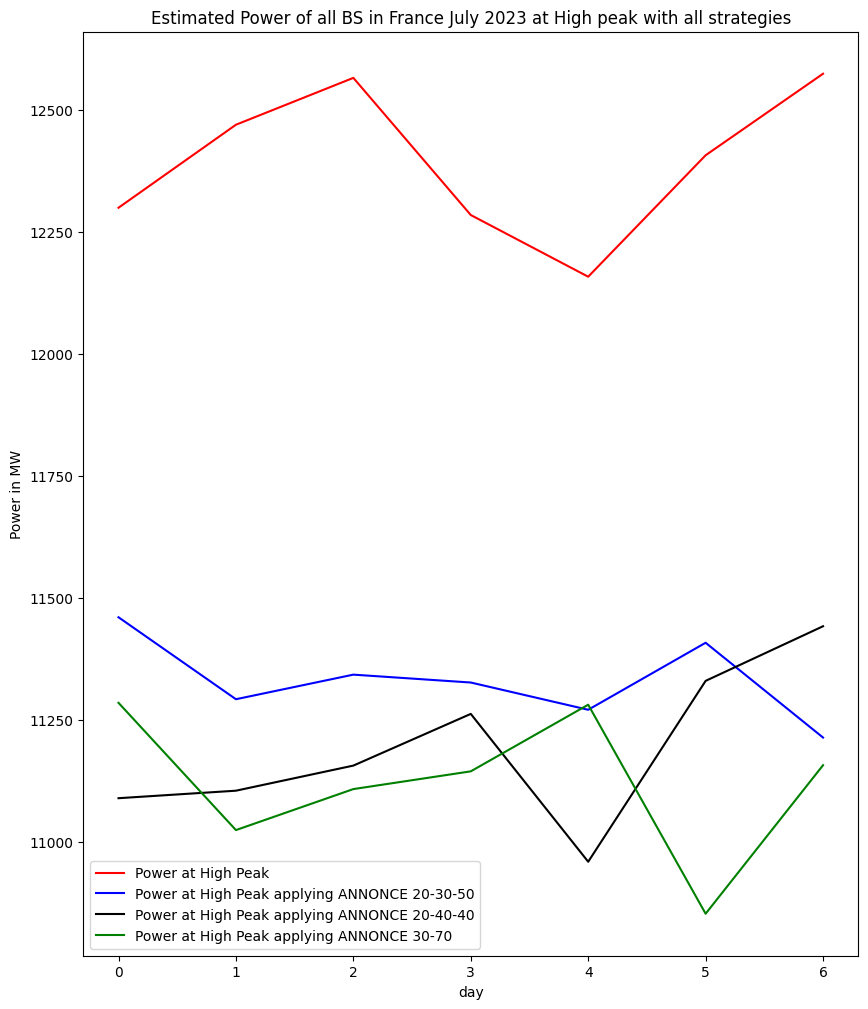

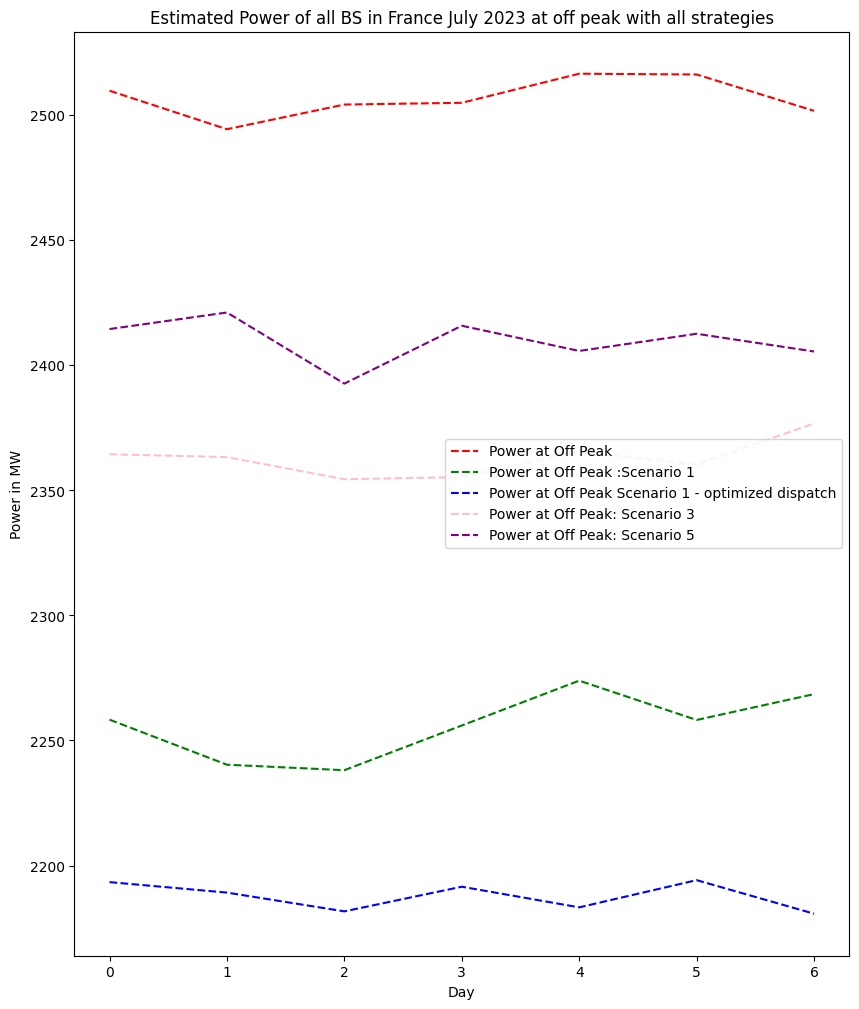

In [99]:
#PLOT WITH 1, FREQ OFF:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 12))

# Set different line colors for each plot
colors = ['red', 'blue', 'green', 'black', 'pink', 'orange', 'purple']
# Plot the data
plt.plot(days, power_highpeak, label='Power at High Peak', color=colors[0])
#plt.plot(days, power_offpeak, label='Power at Off Peak',linestyle='--', color=colors[0])
plt.plot(days, power_annonce_high, label='Power at High Peak applying ANNONCE 20-30-50', color=colors[1])
#plt.plot(days, power_annonce_off, label='Power at Off Peak applying ANNONCE 20-30-50',linestyle='--', color=colors[1])
plt.plot(days, power_freqOff_sc2_high, label='Power at High Peak applying ANNONCE 20-40-40', color=colors[3])
#plt.plot(days, power_freqOff_sc2_off, label='Power at Off Peak applying ANNONCE 20-40-40',linestyle='dotted', color=colors[3])
plt.plot(days, power_freqOff_sc4_high, label='Power at High Peak applying ANNONCE 30-70', color=colors[2])
#plt.plot(days, power_freqOff_sc4_off, label='Power at Off Peak applying ANNONCE 30-70',linestyle='--', color=colors[2])

plt.xlabel('day')
plt.ylabel('Power in MW')
plt.title('Estimated Power of all BS in France July 2023 at High peak with all strategies')
#for x, y in zip(loads, gain):
 #   plt.text(x, y, f'{round(y, 2)}%', ha='right', va='top')
plt.legend()

plt.savefig('./Graphs/with ANNONCE.pdf', format='pdf')
plt.show()

plt.figure(figsize=(10, 12))
#plt.plot(days, power_highpeak, label='Power at High Peak', color=colors[0])
plt.plot(days, power_offpeak, label='Power at Off Peak',linestyle='--', color=colors[0])
#plt.plot(days, power_freqOff_sc1_high, label='Power at High Peak: Scenario 1', color=colors[2])
plt.plot(days, power_freqOff_sc1_off, label='Power at Off Peak :Scenario 1',linestyle='--', color=colors[2])
#plt.plot(days, power_freqOff_sc7_high, label='Power at High Peak: Scenario 1 - optimized dispatch', color=colors[3])
plt.plot(days, power_freqOff_sc7_off, label='Power at Off Peak Scenario 1 - optimized dispatch', color=colors[1],linestyle='--')
#plt.plot(days, power_freqOff_sc3_high, label='Power at High Peak: Scenario 3', color=colors[4])
plt.plot(days, power_freqOff_sc3_off, label='Power at Off Peak: Scenario 3',linestyle='--', color=colors[4])
#plt.plot(days, power_freqOff_sc5_high, label='Power at High Peak: Scenario 5', color=colors[6])
plt.plot(days, power_freqOff_sc5_off, label='Power at Off Peak: Scenario 5',linestyle='--', color=colors[6])
plt.xlabel('Day')
plt.ylabel('Power in MW')
plt.title('Estimated Power of all BS in France July 2023 at off peak with all strategies')
#for x, y in zip(loads, gain):
 #   plt.text(x, y, f'{round(y, 2)}%', ha='right', va='top')
plt.legend()

plt.savefig('./Graphs/with 1freq switched off scenarios.pdf', format='pdf')
plt.show()

In [ ]:
from scipy.interpolate import make_interp_spline

rb_freqOff_sc1 = []
rb_freqOff_sc7 = []
rb_freqOff_sc2 = []
rb_freqOff_sc3 = []
rb_freqOff_sc4 = []
rb_freqOff_sc5 = []
rb_freqOff_annonce = []
for column_name in all_df1.columns[10:]:
    rb_freqOff_sc1.append((all_df[column_name].sum()- all_df1[column_name].sum())*100/all_df[column_name].sum())
    rb_freqOff_annonce.append((all_df[column_name].sum()- all_df6[column_name].sum())*100/all_df[column_name].sum())
    rb_freqOff_sc7.append((all_df[column_name].sum()- all_df7[column_name].sum())*100/all_df[column_name].sum())
    rb_freqOff_sc3.append((all_df[column_name].sum()- all_df3[column_name].sum())*100/all_df[column_name].sum())
    rb_freqOff_sc5.append((all_df[column_name].sum()- all_df5[column_name].sum())*100/all_df[column_name].sum())
    rb_freqOff_sc4.append((all_df[column_name].sum()- all_df4[column_name].sum())*100/all_df[column_name].sum())
    rb_freqOff_sc2.append((all_df[column_name].sum()- all_df2[column_name].sum())*100/all_df[column_name].sum())

# Create a smoother curve using cubic interpolation
loads_smooth = np.linspace(min(loads), max(loads), 300)
rb_freqOff_annonce_smooth = make_interp_spline(loads, rb_freqOff_annonce)(loads_smooth)
rb_freqOff_sc1_smooth = make_interp_spline(loads, rb_freqOff_sc1)(loads_smooth)
rb_freqOff_sc7_smooth = make_interp_spline(loads, rb_freqOff_sc7)(loads_smooth)
rb_freqOff_sc3_smooth = make_interp_spline(loads, rb_freqOff_sc3)(loads_smooth)
rb_freqOff_sc5_smooth = make_interp_spline(loads, rb_freqOff_sc5)(loads_smooth)
rb_freqOff_sc4_smooth = make_interp_spline(loads, rb_freqOff_sc4)(loads_smooth)
rb_freqOff_sc2_smooth = make_interp_spline(loads, rb_freqOff_sc2)(loads_smooth)

plt.figure(figsize=(10, 12))
plt.plot(loads_smooth, rb_freqOff_annonce_smooth, label='% of gain by ANNONCE 20-30-50', color=colors[1])
plt.plot(loads_smooth, rb_freqOff_sc4_smooth, label='% of gain by ANNONCE 30-70', color=colors[1], linestyle='--')
plt.plot(loads_smooth, rb_freqOff_sc2_smooth, label='% of gain by ANNONCE 20-40-40', color=colors[0], linestyle='dotted')





plt.xlabel('% of LOAD on BS')
plt.ylabel('% of Gain ')
plt.title('% OF ENERGY SAVED FOR EACH CASE COMPARED TO UNIFORM LOAD APPLIED TO ALL BS')
#for x, y in zip(loads, gain):
 #   plt.text(x, y, f'{round(y, 2)}%', ha='right', va='top')
plt.legend()
plt.ylim(0)
plt.xlim(0)
plt.savefig('./Graphs/Gain per CASE.pdf', format='pdf')
plt.show()

plt.figure(figsize=(10, 12))
plt.plot(loads_smooth, rb_freqOff_sc1_smooth, label='% of gain by SCENARIO 1', color=colors[2])
plt.plot(loads_smooth, rb_freqOff_sc7_smooth, label='% of gain by SCENARIO 1 Optimized', color=colors[2], linestyle='--')
plt.plot(loads_smooth, rb_freqOff_sc3_smooth, label='% of gain by SCENARIO 3', color=colors[4])
plt.plot(loads_smooth, rb_freqOff_sc5_smooth, label='% of gain by SCENARIO 5', color=colors[6])

plt.xlabel('% of LOAD on BS')
plt.ylabel('% of Gain ')
plt.title('% OF GAIN PER SCENARIO COMPARED TO UNIFORM LOAD TO EVERY BS')
#for x, y in zip(loads, gain):
 #   plt.text(x, y, f'{round(y, 2)}%', ha='right', va='top')
plt.legend()
plt.ylim(0)
plt.xlim(0)
plt.savefig('./Graphs/Gain per scenario.pdf', format='pdf')
plt.show()


In [ ]:
#plot for RB Variation for each Scenario
#SCENARION 1
rb_LTE_700 =[]
rb_LTE_800 = []
rb_LTE_1800 = []
rb_LTE_2100 = []
rb_LTE_2600 = []
rb_5G_700 = []
rb_5G_2100 = []
for column_name in all_df1.columns[10:]:
    rb_LTE_700.append(all_df_temp[all_df_temp['System'] == 'LTE 700'][column_name].sum()/(all_df_temp[all_df_temp['System'] == 'LTE 700'][column_name].sum() + all_df_rb[all_df_rb['System'] == 'LTE 700'][column_name].sum()))
    rb_LTE_800.append(all_df_temp[all_df_temp['System'] == 'LTE 800'][column_name].sum()/(all_df_temp[all_df_temp['System'] == 'LTE 800'][column_name].sum() + all_df_rb[all_df_rb['System'] == 'LTE 800'][column_name].sum()))
    rb_LTE_1800.append(all_df_temp[all_df_temp['System'] == 'LTE 1800'][column_name].sum()/(all_df_temp[all_df_temp['System'] == 'LTE 1800'][column_name].sum() + all_df_rb[all_df_rb['System'] == 'LTE 1800'][column_name].sum()))
    rb_LTE_2100.append(all_df_temp[all_df_temp['System'] == 'LTE 2100'][column_name].sum()/(all_df_temp[all_df_temp['System'] == 'LTE 2100'][column_name].sum() + all_df_rb[all_df_rb['System'] == 'LTE 2100'][column_name].sum()))
    rb_LTE_2600.append(all_df_temp[all_df_temp['System'] == 'LTE 2600'][column_name].sum()/(all_df_temp[all_df_temp['System'] == 'LTE 2600'][column_name].sum() + all_df_rb[all_df_rb['System'] == 'LTE 2600'][column_name].sum()))
    rb_5G_700.append(all_df_temp[all_df_temp['System'] == '5G NR 700'][column_name].sum()/(all_df_temp[all_df_temp['System'] == '5G NR 700'][column_name].sum() + all_df_rb[all_df_rb['System'] == '5G NR 700'][column_name].sum()))
    rb_5G_2100.append(all_df_temp[all_df_temp['System'] == '5G NR 2100'][column_name].sum()/(all_df_temp[all_df_temp['System'] == '5G NR 2100'][column_name].sum() + all_df_rb[all_df_rb['System'] == '5G NR 2100'][column_name].sum()))

# Create a smoother curve using cubic interpolation
loads_smooth = np.linspace(min(loads), max(loads), 65)
rb_LTE_700_smooth = make_interp_spline(loads, rb_LTE_700)(loads_smooth)
rb_LTE_800_smooth = make_interp_spline(loads, rb_LTE_800)(loads_smooth)
rb_LTE_1800_smooth = make_interp_spline(loads, rb_LTE_1800)(loads_smooth)
rb_LTE_2100_smooth = make_interp_spline(loads, rb_LTE_2100)(loads_smooth)
rb_LTE_2600_smooth = make_interp_spline(loads, rb_LTE_2600)(loads_smooth)
rb_5G_700_smooth = make_interp_spline(loads, rb_5G_700)(loads_smooth)
rb_5G_2100_smooth = make_interp_spline(loads, rb_5G_2100)(loads_smooth)

plt.figure(figsize=(10, 12))
plt.plot(loads_smooth, rb_LTE_700_smooth, label='LTE 700', color=colors[1])
plt.plot(loads_smooth, rb_LTE_800_smooth, label='LTE 800', color=colors[1], linestyle='--')
plt.plot(loads_smooth, rb_LTE_1800_smooth, label='LTE 1800', color=colors[0], linestyle='dotted')
plt.plot(loads_smooth, rb_LTE_2100_smooth, label='LTE 2100', color=colors[2])
plt.plot(loads_smooth, rb_LTE_2600_smooth, label='LTE 2600', color=colors[2], linestyle='--')
plt.plot(loads_smooth, rb_5G_700_smooth, label='5G NR 700', color=colors[4])
plt.plot(loads_smooth, rb_5G_2100, label='5G NR 2100', color=colors[6])




plt.xlabel('% of LOAD on BS')
plt.ylabel('NEW RB/ TOTAL RB ')
plt.title('% OF RB PER FREQ IN SCENARION 1')
#for x, y in zip(loads, gain):
 #   plt.text(x, y, f'{round(y, 2)}%', ha='right', va='top')
plt.legend()
plt.ylim(0)
plt.xlim(0)
plt.savefig('./Graphs/RB SCENARIO 1.pdf', format='pdf')
plt.show()

#----------------------------------------------------------SCENARIO 1 bis
rb_LTE_700 =[]
rb_LTE_800 = []
rb_LTE_1800 = []
rb_LTE_2100 = []
rb_LTE_2600 = []
rb_5G_700 = []
rb_5G_2100 = []
for column_name in all_df1.columns[10:]:
    rb_LTE_700.append(all_df_temp7[all_df_temp7['System'] == 'LTE 700'][column_name].sum()/(all_df_temp7[all_df_temp7['System'] == 'LTE 700'][column_name].sum() + all_df_rb[all_df_rb['System'] == 'LTE 700'][column_name].sum()))
    rb_LTE_800.append(all_df_temp7[all_df_temp7['System'] == 'LTE 800'][column_name].sum()/(all_df_temp7[all_df_temp7['System'] == 'LTE 800'][column_name].sum() + all_df_rb[all_df_rb['System'] == 'LTE 800'][column_name].sum()))
    rb_LTE_1800.append(all_df_temp7[all_df_temp7['System'] == 'LTE 1800'][column_name].sum()/(all_df_temp7[all_df_temp7['System'] == 'LTE 1800'][column_name].sum() + all_df_rb[all_df_rb['System'] == 'LTE 1800'][column_name].sum()))
    rb_LTE_2100.append(all_df_temp7[all_df_temp7['System'] == 'LTE 2100'][column_name].sum()/(all_df_temp7[all_df_temp7['System'] == 'LTE 2100'][column_name].sum() + all_df_rb[all_df_rb['System'] == 'LTE 2100'][column_name].sum()))
    rb_LTE_2600.append(all_df_temp7[all_df_temp7['System'] == 'LTE 2600'][column_name].sum()/(all_df_temp7[all_df_temp7['System'] == 'LTE 2600'][column_name].sum() + all_df_rb[all_df_rb['System'] == 'LTE 2600'][column_name].sum()))
    rb_5G_700.append(all_df_temp7[all_df_temp7['System'] == '5G NR 700'][column_name].sum()/(all_df_temp7[all_df_temp7['System'] == '5G NR 700'][column_name].sum() + all_df_rb[all_df_rb['System'] == '5G NR 700'][column_name].sum()))
    rb_5G_2100.append(all_df_temp7[all_df_temp7['System'] == '5G NR 2100'][column_name].sum()/(all_df_temp7[all_df_temp7['System'] == '5G NR 2100'][column_name].sum() + all_df_rb[all_df_rb['System'] == '5G NR 2100'][column_name].sum()))

# Create a smoother curve using cubic interpolation
loads_smooth = np.linspace(min(loads), max(loads), 65)
rb_LTE_700_smooth = make_interp_spline(loads, rb_LTE_700)(loads_smooth)
rb_LTE_800_smooth = make_interp_spline(loads, rb_LTE_800)(loads_smooth)
rb_LTE_1800_smooth = make_interp_spline(loads, rb_LTE_1800)(loads_smooth)
rb_LTE_2100_smooth = make_interp_spline(loads, rb_LTE_2100)(loads_smooth)
rb_LTE_2600_smooth = make_interp_spline(loads, rb_LTE_2600)(loads_smooth)
rb_5G_700_smooth = make_interp_spline(loads, rb_5G_700)(loads_smooth)
rb_5G_2100_smooth = make_interp_spline(loads, rb_5G_2100)(loads_smooth)

plt.figure(figsize=(10, 12))
plt.plot(loads_smooth, rb_LTE_700_smooth, label='LTE 700', color=colors[1])
plt.plot(loads_smooth, rb_LTE_800_smooth, label='LTE 800', color=colors[1], linestyle='--')
plt.plot(loads_smooth, rb_LTE_1800_smooth, label='LTE 1800', color=colors[0], linestyle='dotted')
plt.plot(loads_smooth, rb_LTE_2100_smooth, label='LTE 2100', color=colors[2])
plt.plot(loads_smooth, rb_LTE_2600_smooth, label='LTE 2600', color=colors[2], linestyle='--')
plt.plot(loads_smooth, rb_5G_700_smooth, label='5G NR 700', color=colors[4])
plt.plot(loads_smooth, rb_5G_2100, label='5G NR 2100', color=colors[6])




plt.xlabel('% of LOAD on BS')
plt.ylabel('NEW RB/ TOTAL RB ')
plt.title('% OF RB PER FREQ IN SCENARION 1 bis')
#for x, y in zip(loads, gain):
 #   plt.text(x, y, f'{round(y, 2)}%', ha='right', va='top')
plt.legend()
plt.ylim(0)
plt.xlim(0)
plt.savefig('./Graphs/RB SCENARIO 1 bis.pdf', format='pdf')
plt.show()


#------------------------------------------------SCENARIO 3
rb_LTE_700 =[]
rb_LTE_800 = []
rb_LTE_1800 = []
rb_LTE_2100 = []
rb_LTE_2600 = []
rb_5G_700 = []
rb_5G_2100 = []
for column_name in all_df3.columns[10:]:
    rb_LTE_700.append(all_df_temp3[all_df_temp3['System'] == 'LTE 700'][column_name].sum()/(all_df_temp3[all_df_temp3['System'] == 'LTE 700'][column_name].sum() + all_df_rb[all_df_rb['System'] == 'LTE 700'][column_name].sum()))
    rb_LTE_800.append(all_df_temp3[all_df_temp3['System'] == 'LTE 800'][column_name].sum()/(all_df_temp3[all_df_temp3['System'] == 'LTE 800'][column_name].sum() + all_df_rb[all_df_rb['System'] == 'LTE 800'][column_name].sum()))
    rb_LTE_1800.append(all_df_temp3[all_df_temp3['System'] == 'LTE 1800'][column_name].sum()/(all_df_temp3[all_df_temp3['System'] == 'LTE 1800'][column_name].sum() + all_df_rb[all_df_rb['System'] == 'LTE 1800'][column_name].sum()))
    rb_LTE_2100.append(all_df_temp3[all_df_temp3['System'] == 'LTE 2100'][column_name].sum()/(all_df_temp3[all_df_temp3['System'] == 'LTE 2100'][column_name].sum() + all_df_rb[all_df_rb['System'] == 'LTE 2100'][column_name].sum()))
    rb_LTE_2600.append(all_df_temp3[all_df_temp3['System'] == 'LTE 2600'][column_name].sum()/(all_df_temp3[all_df_temp3['System'] == 'LTE 2600'][column_name].sum() + all_df_rb[all_df_rb['System'] == 'LTE 2600'][column_name].sum()))
    rb_5G_700.append(all_df_temp3[all_df_temp3['System'] == '5G NR 700'][column_name].sum()/(all_df_temp3[all_df_temp3['System'] == '5G NR 700'][column_name].sum() + all_df_rb[all_df_rb['System'] == '5G NR 700'][column_name].sum()))
    rb_5G_2100.append(all_df_temp3[all_df_temp3['System'] == '5G NR 2100'][column_name].sum()/(all_df_temp3[all_df_temp3['System'] == '5G NR 2100'][column_name].sum() + all_df_rb[all_df_rb['System'] == '5G NR 2100'][column_name].sum()))

# Create a smoother curve using cubic interpolation
loads_smooth = np.linspace(min(loads), max(loads), 65)
rb_LTE_700_smooth = make_interp_spline(loads, rb_LTE_700)(loads_smooth)
rb_LTE_800_smooth = make_interp_spline(loads, rb_LTE_800)(loads_smooth)
rb_LTE_1800_smooth = make_interp_spline(loads, rb_LTE_1800)(loads_smooth)
rb_LTE_2100_smooth = make_interp_spline(loads, rb_LTE_2100)(loads_smooth)
rb_LTE_2600_smooth = make_interp_spline(loads, rb_LTE_2600)(loads_smooth)
rb_5G_700_smooth = make_interp_spline(loads, rb_5G_700)(loads_smooth)
rb_5G_2100_smooth = make_interp_spline(loads, rb_5G_2100)(loads_smooth)

plt.figure(figsize=(10, 12))
plt.plot(loads_smooth, rb_LTE_700_smooth, label='LTE 700', color=colors[1])
plt.plot(loads_smooth, rb_LTE_800_smooth, label='LTE 800', color=colors[1], linestyle='--')
plt.plot(loads_smooth, rb_LTE_1800_smooth, label='LTE 1800', color=colors[0], linestyle='dotted')
plt.plot(loads_smooth, rb_LTE_2100_smooth, label='LTE 2100', color=colors[2])
plt.plot(loads_smooth, rb_LTE_2600_smooth, label='LTE 2600', color=colors[2], linestyle='--')
plt.plot(loads_smooth, rb_5G_700_smooth, label='5G NR 700', color=colors[4])
plt.plot(loads_smooth, rb_5G_2100, label='5G NR 2100', color=colors[6])




plt.xlabel('% of LOAD on BS')
plt.ylabel('NEW RB/ TOTAL RB ')
plt.title('% OF RB PER FREQ IN SCENARION 3')
#for x, y in zip(loads, gain):
 #   plt.text(x, y, f'{round(y, 2)}%', ha='right', va='top')
plt.legend()
plt.ylim(0)
plt.xlim(0)
plt.savefig('./Graphs/RB SCENARIO 3.pdf', format='pdf')
plt.show()

#---------------------------------SCENARIO 5
rb_LTE_700 =[]
rb_LTE_800 = []
rb_LTE_1800 = []
rb_LTE_2100 = []
rb_LTE_2600 = []
rb_5G_700 = []
rb_5G_2100 = []
for column_name in all_df5.columns[10:]:
    rb_LTE_700.append(all_df_temp5[all_df_temp5['System'] == 'LTE 700'][column_name].sum()/(all_df_temp5[all_df_temp5['System'] == 'LTE 700'][column_name].sum() + all_df_rb[all_df_rb['System'] == 'LTE 700'][column_name].sum()))
    rb_LTE_800.append(all_df_temp5[all_df_temp5['System'] == 'LTE 800'][column_name].sum()/(all_df_temp5[all_df_temp5['System'] == 'LTE 800'][column_name].sum() + all_df_rb[all_df_rb['System'] == 'LTE 800'][column_name].sum()))
    rb_LTE_1800.append(all_df_temp5[all_df_temp5['System'] == 'LTE 1800'][column_name].sum()/(all_df_temp5[all_df_temp5['System'] == 'LTE 1800'][column_name].sum() + all_df_rb[all_df_rb['System'] == 'LTE 1800'][column_name].sum()))
    rb_LTE_2100.append(all_df_temp[all_df_temp['System'] == 'LTE 2100'][column_name].sum()/(all_df_temp5[all_df_temp5['System'] == 'LTE 2100'][column_name].sum() + all_df_rb[all_df_rb['System'] == 'LTE 2100'][column_name].sum()))
    rb_LTE_2600.append(all_df_temp5[all_df_temp5['System'] == 'LTE 2600'][column_name].sum()/(all_df_temp5[all_df_temp5['System'] == 'LTE 2600'][column_name].sum() + all_df_rb[all_df_rb['System'] == 'LTE 2600'][column_name].sum()))
    rb_5G_700.append(all_df_temp5[all_df_temp5['System'] == '5G NR 700'][column_name].sum()/(all_df_temp5[all_df_temp5['System'] == '5G NR 700'][column_name].sum() + all_df_rb[all_df_rb['System'] == '5G NR 700'][column_name].sum()))
    rb_5G_2100.append(all_df_temp5[all_df_temp5['System'] == '5G NR 2100'][column_name].sum()/(all_df_temp5[all_df_temp5['System'] == '5G NR 2100'][column_name].sum() + all_df_rb[all_df_rb['System'] == '5G NR 2100'][column_name].sum()))

# Create a smoother curve using cubic interpolation
loads_smooth = np.linspace(min(loads), max(loads), 65)
rb_LTE_700_smooth = make_interp_spline(loads, rb_LTE_700)(loads_smooth)
rb_LTE_800_smooth = make_interp_spline(loads, rb_LTE_800)(loads_smooth)
rb_LTE_1800_smooth = make_interp_spline(loads, rb_LTE_1800)(loads_smooth)
rb_LTE_2100_smooth = make_interp_spline(loads, rb_LTE_2100)(loads_smooth)
rb_LTE_2600_smooth = make_interp_spline(loads, rb_LTE_2600)(loads_smooth)
rb_5G_700_smooth = make_interp_spline(loads, rb_5G_700)(loads_smooth)
rb_5G_2100_smooth = make_interp_spline(loads, rb_5G_2100)(loads_smooth)

plt.figure(figsize=(10, 12))
plt.plot(loads_smooth, rb_LTE_700_smooth, label='LTE 700', color=colors[1])
plt.plot(loads_smooth, rb_LTE_800_smooth, label='LTE 800', color=colors[1], linestyle='--')
plt.plot(loads_smooth, rb_LTE_1800_smooth, label='LTE 1800', color=colors[0], linestyle='dotted')
plt.plot(loads_smooth, rb_LTE_2100_smooth, label='LTE 2100', color=colors[2])
plt.plot(loads_smooth, rb_LTE_2600_smooth, label='LTE 2600', color=colors[2], linestyle='--')
plt.plot(loads_smooth, rb_5G_700_smooth, label='5G NR 700', color=colors[4])
plt.plot(loads_smooth, rb_5G_2100, label='5G NR 2100', color=colors[6])




plt.xlabel('% of LOAD on BS')
plt.ylabel('NEW RB/ TOTAL RB ')
plt.title('% OF RB PER FREQ IN SCENARION 5')
#for x, y in zip(loads, gain):
 #   plt.text(x, y, f'{round(y, 2)}%', ha='right', va='top')
plt.legend()
plt.ylim(0)
plt.xlim(0)
plt.savefig('./Graphs/RB SCENARIO 5.pdf', format='pdf')
plt.show()
